# Shortlisting Players for a Champions League Club

- Change `get_df_pos` to take *df_players* input rather than create it everytime itself.
- Change `get_df_style` to take no default *attr* value.

In this notebook I will attempt to shortlist players from the provided data for a Champions League club. In particular, the team is looking for a **Defensive Midfielder**, a **Centre Back** and a **Winger**.

In [539]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patheffects, lines
from matplotlib.patches import Circle,FancyArrowPatch
from textwrap import fill,wrap
from highlight_text.htext import htext
from palettable.cartocolors.sequential import Sunset_7
from palettable.colorbrewer.diverging import RdYlGn_9
from datetime import datetime, date
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns # Used for quick heatmap visualisation of PCA results

plt.style.use('football')

%matplotlib inline

In [ ]:
plt.rcParams['pdf.fonttype'] = 42

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 3)

In [3]:
df = pd.read_csv("data_analyst_task_data.csv")

In [4]:
print("There are",len(df['team_id'].unique()),"teams in the data set.")
print("There are",len(df['player_id'].unique()),"unique players in the data set.")

There are 20 teams in the data set.


In [6]:
df.head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded
0,56448,1991-02-16,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0
1,140264,1990-05-24,869728,Midfielder,64,953,90,1,8,2,2,2,2,1,3,3,0,0,1,7,0,7,0,51,13,0,44,0,0,0,0,0,0,2,0,0.051,0,0,0,0,0,1
2,126290,1991-07-18,869481,Midfielder,34,953,90,1,1,2,2,0,2,2,3,1,0,0,1,2,4,14,2,14,2,0,8,0,0,0,1,1,4,1,0,0.058,1,0,0,0,0,1
3,58906,1986-11-21,869573,Midfielder,15,616,21,0,1,0,0,0,0,1,1,2,0,0,1,1,0,1,0,9,2,0,9,0,0,0,0,1,0,0,0,0.000,0,0,0,0,0,0
4,39817,1984-06-12,869642,Midfielder,96,449,90,1,11,2,2,1,0,1,3,1,0,0,0,20,2,8,0,87,2,0,80,0,0,1,0,1,0,0,0,0.000,0,0,0,0,0,2


## Create DataFrame with player personal information

Create a DataFrame called *df_players* that will contain the personal information like minutes played, 90s played, age, games played, number of starts and position.

Start with total minutes played by each player:

In [7]:
df_players = pd.DataFrame(df.groupby('player_id')['mins_played'].sum())

90s played:

In [8]:
df_players['90s'] = df_players['mins_played']/90

To find the age of a player it must be calculated from their birth date. I use the ``datetime`` module to help with this:

In [9]:
def calculate_age(birth_date):
    today = date.today()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age

In [10]:
birth_dates = []
for pid in df_players.index:
    player = df[df['player_id'] == pid]
    birth_date = datetime.strptime(player['player_birth_date'].iloc[0], "%Y-%m-%d").date()
    birth_dates.append(calculate_age(birth_date))

In [11]:
df_players['age'] = birth_dates

Games played and number of starts:

In [12]:
df_players['gp'] = df.groupby('player_id').size()
df_players['games_started'] = df.groupby('player_id')['game_started'].sum()

Position of each player. First check that the position of a player does not change.

In [13]:
for pid in df['player_id'].unique():
    if len(df[df['player_id'] == 140264]['position'].value_counts()) < 1:
        print('More than one position')

We see that every player has a single position. Now find position of every player:

In [14]:
df_players['position'] = np.ravel(df.groupby('player_id')['position'].unique().to_list())

In [15]:
df_players.head()

,mins_played,90s,age,gp,games_started,position
player_id,,,,,,
7088,2051,22.789,38,32,22,Defender
7261,540,6.000,39,16,6,Defender
10316,1675,18.611,39,31,19,Midfielder
10343,864,9.600,36,30,10,Midfielder
11129,3240,36.000,30,36,36,Defender


### Age distribution

Which is the age distribution of all players? And what does it look like by position?

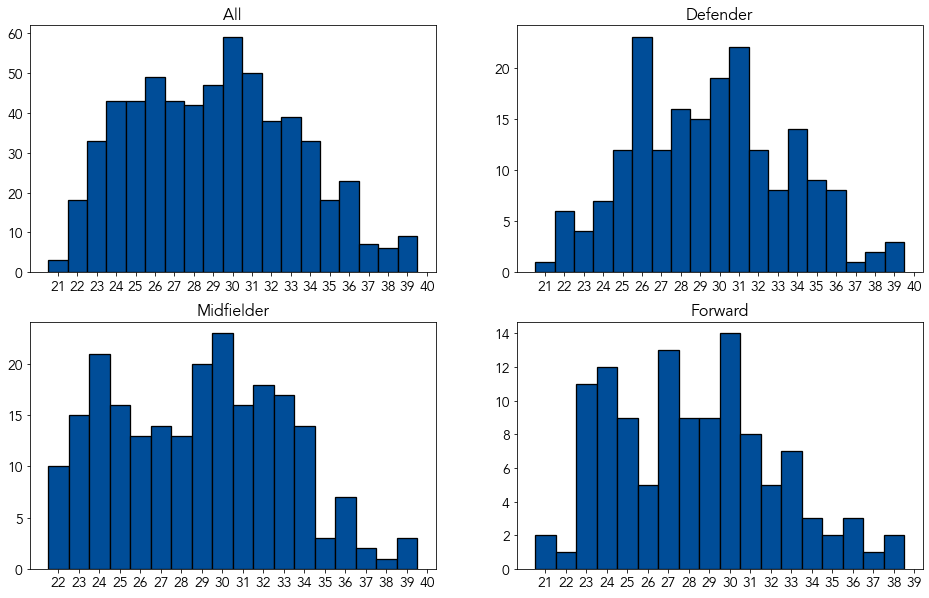

In [17]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,6))

for i,pos in enumerate(['All','Defender','Midfielder','Forward']):
    if pos == 'All':
        age_vals = df_players['age'].to_numpy()
    else:
        age_vals = df_players[df_players['position'] == pos]['age'].to_numpy()
    bins = np.arange(age_vals.min(),age_vals.max()+1,1)
    axs[i//2,i%2].hist(age_vals,bins=bins,align='left',label=pos)
    axs[i//2,i%2].set_title(pos)
    axs[i//2,i%2].set_xticks(bins)

plt.show()

Interestingly, we see that the youngest player is 21 years old. There are very few defenders 24 years and younger. Midfielders have the largest population of under 25s.

## Team Ranking

I thought about calculating the points each team ended the season with by using *game_id*, *team_id* and *goals*. However, *goals* does not include own goals so the results won't be completely accurate. Neverthelss, they could serve as a reasonable estimator of team performance over the season.

In [18]:
df_games = df.groupby(['game_id','team_id'])['goals'].sum().reset_index()

In [19]:
team_points = {}
gp = {}
wins = {}
draws = {}
loss = {}
for gid in df_games['game_id'].unique():
    df_game = df_games[df_games['game_id'] == gid].copy()
    gp[df_game.iloc[0]['team_id']] = gp.get(df_game.iloc[0]['team_id'],0) + 1
    gp[df_game.iloc[1]['team_id']] = gp.get(df_game.iloc[1]['team_id'],0) + 1
    if df_game.iloc[0]['goals'] > df_game.iloc[1]['goals']:
        t1 = df_game.iloc[0]['team_id']
        t2 = df_game.iloc[1]['team_id']
        team_points[t1] = team_points.get(t1, 0) + 3
        team_points[t2] = team_points.get(t2, 0) + 0
        wins[t1] = wins.get(t1,0) + 1
        loss[t2] = loss.get(t2,0) + 1
    elif df_game.iloc[0]['goals'] < df_game.iloc[1]['goals']:
        t1 = df_game.iloc[0]['team_id']
        t2 = df_game.iloc[1]['team_id']
        team_points[t1] = team_points.get(t1, 0) + 0
        team_points[t2] = team_points.get(t2, 0) + 3
        wins[t2] = wins.get(t2,0) + 1
        loss[t1] = loss.get(t1,0) + 1
    elif df_game.iloc[0]['goals'] == df_game.iloc[1]['goals']:
        t1 = df_game.iloc[0]['team_id']
        t2 = df_game.iloc[1]['team_id']
        team_points[t1] = team_points.get(t1, 0) + 1
        team_points[t2] = team_points.get(t2, 0) + 1
        draws[t1] = draws.get(t1,0) + 1
        draws[t2] = draws.get(t2,0) + 1
    else:
        print("Error")

In [20]:
df_points = pd.Series(team_points).sort_values(ascending=False)
df_points.head()

### Approximate Possession

Possession can be approximated as the share of passes a team has in a game. Using the *total_pass* and *total_cross* variables the only unaccounted for passes are throw-ins and keeper throws, so this should be a reasonable approximation. These possession values can then be used to adjust defensive statistics.

Start by finding the number of passes played by each team in each game.

In [21]:
df_passes = df.groupby(['game_id','team_id'])[['total_pass','total_cross']].sum().sum(axis=1).reset_index()
df_passes.rename(columns={0:'passes'},inplace=True)

In [22]:
df_passes.head()

,game_id,team_id,passes
0,869457,186,551
1,869457,188,440
2,869458,182,419
3,869458,450,337
4,869459,177,203


Find the fractions of passes in each game, which will act as the possession estimate.

In [23]:
poss = []
for gid in df_passes['game_id'].unique():
    df_game = df_passes[df_passes['game_id'] == gid]
    poss.append(df_game.iloc[0]['passes'] / df_game['passes'].sum())
    poss.append(df_game.iloc[1]['passes'] / df_game['passes'].sum())

In [24]:
df_passes['poss'] = poss
df_passes.head()

## Possession Adjusting Defensive Attributes

When looking at defensive metrics it is becomes harder to definitively say what is good - it is more stylistic. One big issue is teams that have less possession will have more defending to do and therefore their players will tend to perform more defensive actions.

One way to get around this is to adjust the defensive statistics by the possession the team has. Then players should be able to be compared defensively on a more equal footing. 

From there it is still not a case of "*more tackles means a better defender*". It remains more of a case of style, as mentioned. A defender with a higher attempted adjusted tackle total likes to engage more - whether this is personal or team instructions. Tackle success % is a measure to show how successful they are.

Variables that should to be possession adjusted are *total_tackle*, *won_tackle*, *aerial_won*, *aerial_lost*, *interception* and *total_clearance*. However, I will likely use *won_tackle* to calculate *tackle %* and *aerial_lost* to calculate *aerial %* so do that before possession adjusting.

Start by combining the original DataFrame with the recently calculated possession values. This results in a DataFrame detailing every player in every match with an additional column representing their team's possession in that game.

In [26]:
df_adj = pd.merge(df,df_passes,on=['game_id','team_id'])

In [27]:
df_adj[df_adj['game_id'] == 869705].head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded,passes,poss
754,88554,1992-11-22,869705,Midfielder,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,407,0.448
755,59325,1991-06-21,869705,Midfielder,31,180,54,1,0,3,0,0,2,3,0,0,0,0,0,4,2,14,0,21,1,0,13,0,0,0,0,3,1,1,0,0.062,0,0,0,0,0,0,407,0.448
756,20062,1985-06-07,869705,Midfielder,7,180,14,0,1,1,0,0,0,2,0,1,0,0,0,2,0,3,0,6,1,0,3,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,407,0.448
757,61960,1988-05-27,869705,Midfielder,51,180,90,1,6,3,2,2,5,3,0,0,0,0,0,9,1,9,0,38,3,0,31,0,0,1,1,1,1,2,0,0.103,0,0,0,0,0,1,407,0.448
758,92724,1988-08-01,869705,Midfielder,68,180,90,1,13,0,4,3,1,1,0,0,0,0,3,4,8,13,7,46,4,0,42,0,0,0,1,2,1,1,0,0.028,0,0,0,0,0,1,407,0.448


There are two main methods to possession adjust. The Simple Approach is to just multiply the quantity by $\frac{0.5}{\text{opp. poss.}}$. However, this can become rather extreme and large/small possession values. Instead, I will use the other common approach which is a sigmoid function of the form:
$$
x \times \frac{2}{1+\text{e}^{-0.1\cdot(p-50)}}\ ,
$$
where $x$ is the quantity to be adjusted and $p$ is the team's own possession percentage (0 min, 100 max).

Use this to adjust the *total_tackle*, *aerial_won*, *interception* and *total_clearance* attributes.

In [30]:
# Sigmoid adjustment (behaves better at extremes)
def poss_adj(row):
    total_tackle_adj = (row['total_tackle']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    aerial_won_adj = (row['aerial_won']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    interception_adj = (row['interception']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    total_clearance_adj = (row['total_clearance']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    return total_tackle_adj, aerial_won_adj, interception_adj, total_clearance_adj

In [31]:
df_adj['total_tackle_adj'], df_adj['aerial_won_adj'], df_adj['interception_adj'], df_adj['total_clearance_adj'] = zip(*df_adj.apply(poss_adj,axis=1))

In [33]:
df_adj.head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded,passes,poss,total_tackle_adj,aerial_won_adj,interception_adj,total_clearance_adj
0,56448,1991-02-16,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,522,0.601,0.000,0.000,0.000,0.000
1,84086,1990-03-08,869636,Midfielder,38,188,34,0,4,1,4,3,1,1,1,1,0,0,1,3,1,4,0,29,6,0,25,0,0,0,1,1,0,0,0,0.0,0,0,0,0,0,0,522,0.601,5.870,1.468,1.468,1.468
2,17512,1983-08-29,869636,Midfielder,64,188,90,1,7,4,2,1,0,1,1,0,0,0,0,7,6,17,4,49,5,0,40,0,0,1,0,0,0,0,0,0.0,0,0,1,0,0,0,522,0.601,2.935,0.000,1.468,0.000
3,176163,1996-11-20,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,522,0.601,0.000,0.000,0.000,0.000
4,46998,1987-07-02,869636,Midfielder,67,188,90,1,7,2,1,1,2,0,1,1,0,0,2,3,10,15,9,45,2,0,38,0,4,3,2,2,1,0,0,0.0,0,0,1,0,0,0,522,0.601,1.468,2.935,1.468,2.935


## Identifying Player Roles using Principal Component Analysis (PCA)

PCA is a method of reducing the variable space by determining the directions of maximum variation. It can be used to identify player roles from a large set of attributes, with the idea being that different roles with have greater dependencies on different attributes.

I tried using PCA on the whole data set to identify but really ran into difficulties identify Principal Components with roles. This was even still an issue when trying to discern different roles from the *Midfielders* and *Forwards*. However, I found this application very useful when trying to separate *Centre Backs* and *Full Backs* in the *Defenders* position. These are the two main positions in the defensive line and often quite distinct in their roles, making this is a good candidate for identifying with PCA.

Start by identifying the attributes that will be used.

In [955]:
pca_attr = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj',
            'pen_area_entries','poss_lost_all','total_cross','total_pass',
            'total_long_balls','accurate_pass','accurate_cross',
            'total_att_assist','won_contest','total_contest','touches_in_opp_box','total_scoring_att','goals',
            'expected_goals','ontarget_scoring_att']

I will use all *Defenders* to have played at least 10 90s.

In [956]:
df_pca_p90,df_pca_p90_per = get_df_pos(df_adj,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Midfielder','Forward'])

It is important to standardise all attribute values before performing PCA. This is done by taking
$$
\frac{x-\bar{x}}{\sigma}\ ,
$$
where $\bar{x}$ is the mean of attribute $x$ and $\sigma$ is the standard deviation of that attribute. `sklearn` has the function `scale` to do this.

In [957]:
X = preprocessing.scale(df_pca_p90[pca_attr])

Now perform PCA on all the attributes where we are looking for two principal components - one for Centre Back and one for Fall Back.

In [958]:
pca = PCA(n_components=2)
pca.fit_transform(X);

In [959]:
comp_rel = pca.components_;

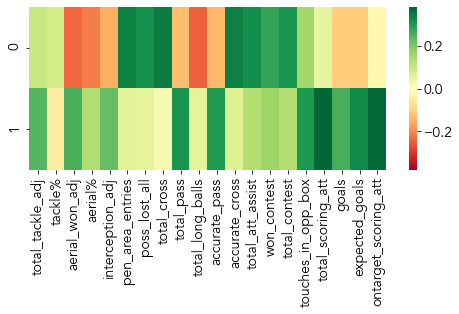

In [961]:
fig = plt.figure(figsize=(8,3))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')

So it appears component 0 corresponds more to FBs, corresponding strongly to *area entries*, *crossing* and *dribbling* and not corresponding to *aerial*, *passing* and *long passing* numbers and, interestingly but I guess because of set pieces, *goals* and *shots*.

It seems CB can be distinguished by a large negative dependence on the Principal Component 0, rather than looking for FB with a large negative dependence on Principal Component 1.

Create a DataFrame of each *Defender* and their value in each principal component. Those with a negative value in Principal Component 1 will be considered Centre Backs for this analysis.

In [963]:
df_fbcb_pca = pd.DataFrame(data=pca.fit_transform(X),columns=['fb','cb'],index=df_pca_p90_per.index)
df_fbcb_pca.head()

,fb,cb
player_id,,
7088,0.272,-2.405
11129,-2.108,0.591
14095,-2.570,1.325
14729,-2.276,-1.695
17804,2.578,-2.030


## Shortlisting

With some basic data sorting done I will now attempt to shortlist players. My main approach is to compare all players within a relevant population, where this population is based on the role at hand, age and minutes played. I will use percentile ranks in each attribute to show how a player compares to the rest of the population. Three choices will be picked for each position. My process works something like this:
- Pick the positions I think will be relevant for the role. For example, Midfielders and Forwards for Winger.
- Choose the attributes I think will be relevant for the role.
- Decide on an age range and number of 90s played. I have mostly used at least 20 90s played with the reason that a Champions League club will be looking for players playing regularly at a good level.
- Calculate players' percentile ranks in the chosen relevant attributes. Sum these percentile ranks and take an initial, rough top 20 players.
- From here more specific styles are investigated by looking at rankings in specific attributes.
- A shortlist is then created from those that perform well in specific styles and overall. At this stage age is also considered, with a preference for younger players who should have more years performing at their peak ahead of them.

In addition to just considering rankings in attributes, it is also important to put these values into context. For that I will also look at a player's, and their team's, style. By this I mean to answer the question "What does a player/team try to do with/without the ball?" These styles are based purely on quantity of actions, rather than any quality. Styles will appear in the visualisations alongside attribute rankings to provide this context.

To help in this endeavour I have created a function `get_df_pos` which returns DataFrames of players for both their raw attribute values and their percentile ranks in each attribute. This function requires a list of attributes and can take a number of 90s limit, an age range, and a list of positions to exclude from the analysis.

In [ ]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

In [39]:
def get_df_pos(df,attr,nineties=10,age_range=None,exclude_pos=['Goalkeeper']):
    """ Function to get two dataframes of players with the per 90 and per 90 percentiles of the specified relevent 
    attributes. """
    all_attr = [i for i in df.columns if i not in ['player_id', 'player_birth_date', 'game_id', 'position','team_id', 'mins_played','game_started','passes','poss']]
    
    # Create a player dataframe with personal stats
    df_players = pd.DataFrame(df.groupby('player_id')['mins_played'].sum())
    df_players['90s'] = df_players['mins_played']/90
    birth_dates = []
    for pid in df_players.index:
        player = df[df['player_id'] == pid]
        birth_date = datetime.strptime(player['player_birth_date'].iloc[0], "%Y-%m-%d").date()
        birth_dates.append(calculate_age(birth_date))
    df_players['age'] = birth_dates
    df_players['gp'] = df.groupby('player_id').size()
    df_players['games_started'] = df.groupby('player_id')['game_started'].sum()
    df_players['position'] = np.ravel(df.groupby('player_id')['position'].unique().to_list())
    
    # Create dataframe of player stat totals
    df_total = pd.concat([df_players, df.groupby('player_id')[all_attr].sum()], axis=1)
    df_total['xG/shot'] = df_total['expected_goals'] / df_total['total_scoring_att']
    df_total['pass%'] = df_total['accurate_pass'] / df_total['total_pass']
    df_total['cross%'] = df_total['accurate_cross'] / df_total['total_cross']
    df_total['contest%'] = df_total['won_contest'] / df_total['total_contest']
    df_total['tackle%'] = df_total['won_tackle'] / df_total['total_tackle']
    df_total['aerial%'] = df_total['aerial_won'] / (df_total['aerial_won'] + df_total['aerial_lost'])
    df_total['long_ball_to_pass%'] = df_total['total_long_balls'] / df_total['total_pass']
    df_total.fillna(0,inplace=True)
    # Player stat p90 values
    df_total_p90 = pd.concat([df_players,df_total.groupby('player_id')[all_attr].sum().div(df_players['90s'], axis=0).fillna(0)], axis=1)
    df_total_p90['xG/shot'] = df_total['xG/shot']
    df_total_p90['pass%'] = df_total['pass%']
    df_total_p90['cross%'] = df_total['cross%']
    df_total_p90['contest%'] = df_total['contest%']
    df_total_p90['tackle%'] = df_total['tackle%']
    df_total_p90['aerial%'] = df_total['aerial%']
    df_total_p90['long_ball_to_pass%'] = df_total['long_ball_to_pass%']
    
    # Create dataframe focusing on the specified important stats
    df_pos = df_total[['mins_played', '90s', 'age', 'gp', 'games_started', 'position']+attr]
    df_pos_p90 = df_total_p90[['mins_played', '90s', 'age', 'gp', 'games_started', 'position']+attr]
    
    # Filter by 90s played
    df_pos_p90 = df_pos_p90[df_pos_p90['90s'] >= nineties].copy()
    # Excluding positions
    if exclude_pos:
        df_pos_p90 = df_pos_p90[~df_pos_p90['position'].isin(exclude_pos)].copy()
    # Age range
    if age_range:
        df_pos_p90 = df_pos_p90[(df_pos_p90['age'] >= age_range[0])&(df_pos_p90['age'] <= age_range[1])].copy()
        
    # Calculate percentiles
    df_pos_p90_per = df_pos_p90.copy()
    for a in attr:
        df_pos_p90_per[a] = df_pos_p90[a].apply(lambda x: stats.percentileofscore(df_pos_p90[a],x))
    # Flip attributes where lower is better such that higher percentile again means better
    if 'poss_lost_all' in attr:
        df_pos_p90_per['poss_lost_all'] = 100 - df_pos_p90_per['poss_lost_all']
    if 'fouls' in attr:
        df_pos_p90_per['fouls'] = 100 - df_pos_p90_per['fouls']
    if 'error_lead_to_goal' in attr:
        df_pos_p90_per['error_lead_to_goal'] = 100 - df_pos_p90_per['error_lead_to_goal']
    if 'error_lead_to_shot' in attr:
        df_pos_p90_per['error_lead_to_shot'] = 100 - df_pos_p90_per['error_lead_to_shot']
    
    return df_pos_p90, df_pos_p90_per

Next, the `get_df_style` function returns a DataFrame with the style ratings in a series of specified *styles* based on provided *attributes*. This can be used for both players and teams by specifying the *team* argument. 

While the ratings in many styles can be given by a single attribute (for example *shooting* is just given by the number of shots attempted *total_scoring_att*), there are some style ratings that take multiple attributes into account. If this is the case I use Principal Component Analysis (PCA) to reduce these multiple attributes into a single attribute which describes the style in question. For example, for *Wingers* I have a *Creation* style that takes into account Key Passes (*total_att_assist*), Total Through Ball Attempts (*total_through_ball*) and Penalty Area Entries (*pen_area_entries*). PCA reduces this to a single component in which each player then has a rating. The range of these ratings is then rescaled to 0-1 to match the range of all other attributes.

A player's style is always compared to all players in the relevant positions to have played at least 10 90s. This is typically a larger population than that used when shortlisting players but, I believe, provides a better picture of a player's style.

In [53]:
def get_df_style(df,attrs=[shot_attr,pass_attr,drib_attr,cross_attr,creat_attr],
                 styles=['shot','pass','drib','cross','creat'],nineties=10,exclude_pos=['Goalkeeper','Defender'],
                team=False,special_pos=False):
    
    if team is False:
        # Flatten attrs list for get_df_pos
        style_attr = [j for i in attrs for j in i]
        # Get the DataFrames for the given attributes, nineties and positions
        df_pos_p90,df_pos_p90_per = get_df_pos(df,style_attr,nineties=nineties,exclude_pos=exclude_pos)
        
        if special_pos == 'Centre Back':
            df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
            df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
            df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
            df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()
        
        # Create the style DataFrame
        df_style = pd.DataFrame(index=df_pos_p90_per.index)
        for i,group in enumerate(attrs):
            if len(group) > 1:
                X = preprocessing.scale(df_pos_p90_per[group])
                pca = PCA(n_components=1)
                df_style[styles[i]] = pca.fit_transform(X)
            else:
                df_style[styles[i]] = df_pos_p90_per[group].to_numpy()
        
        if 'foul' in styles:
            df_style['foul'] = 100 - df_style['foul']
        
        df_style = df_style.apply(lambda x: change_range(x,(x.min(),x.max()),(0,1)))
    else:
        style_attr = [j for i in attrs for j in i]
        df_team = df.groupby('team_id')[style_attr].sum()
        # Calculate percentiles
        df_team_per = df_team.copy()
        for a in style_attr:
                df_team_per[a] = df_team[a].apply(lambda x: stats.percentileofscore(df_team[a],x))
    
        df_style = pd.DataFrame(index=df_team_per.index)
        for i,group in enumerate(attrs):
            if len(group) > 1:
                X = preprocessing.scale(df_team_per[group])
                pca = PCA(n_components=1)
                df_style[styles[i]] = pca.fit_transform(X)
            else:
                df_style[styles[i]] = df_team_per[group].to_numpy()

        df_style = df_style.apply(lambda x: change_range(x,(x.min(),x.max()),(0,1)))
    
    return df_style

## Visualisation

The `plot_bars` function is used to create a horizontal bar chart displaying a player's percentile ranking in the specified attributes. It is presented in an "above/below median" form to emphasise how a player performs in comparison to their peers.

In [909]:
def plot_bars(df_players,df_pos_p90,df_pos_p90_per,attrs,pid,bar_cmap='RdYlGn',annotations=True,ax=None,
              attr_labels=['xG','Shots','xG/Shot','Key Passes','Passing %','Crosses','Touches in Box','Successful Dribbles','Poss. Losses'],
             alpha=0.8,fs=12,pelw=2):
    
    df_pos_p90 = df_pos_p90[attrs]
    df_pos_p90_per = df_pos_p90_per[attrs]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    cmap = plt.get_cmap(bar_cmap)
    norm = mpl.colors.Normalize(vmin=0, vmax=100)

    y_range = np.arange(len(attrs),0,-1)

    ax.barh(np.arange(len(attrs),0,-1),df_pos_p90_per.loc[pid].values - 50,left=50,color=cmap(norm(df_pos_p90_per.loc[pid].values)),alpha=alpha)
    ax.axvline(50,c='k',lw=1,ls='--')
    for i,attr in enumerate(attrs):
        if df_pos_p90_per.loc[pid,attr] >= 75:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
        elif df_pos_p90_per.loc[pid,attr] >= 50:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
        elif df_pos_p90_per.loc[pid,attr] <= 25:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
        else:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])

    ax.set_xlim(0,100)
    ax.set_yticks(np.arange(len(attrs),0,-1))
    ax.set_yticklabels(attr_labels,size=fs,weight='medium')
    ax.set_xticks(np.arange(0,125,25))
    ax.tick_params(bottom=False,left=False,labelbottom=False)
    for i in ['top','bottom']:
        ax.spines[i].set_visible(False)

    ax.grid(axis='x',ls='--',alpha=1)
    ax.text(0.5,1,'Median',ha='center',va='bottom',transform=ax.transAxes,size=fs)
    
    if annotations:
        ax.text(0,1.22,"Player ID: {}".format(pid),transform=ax.transAxes,fontsize=fs,fontweight='bold',ha='left',va='bottom')
        ax.text(0,1.15,"{}".format(df_players.loc[pid,'position']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='left',va='bottom')
        ax.text(0,1.1,"Values per 90 minutes played",transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='left',va='bottom')

        ax.text(1.,1.22,"Age: {}".format(df_players.loc[pid,'age']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.15,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.1,"{} Games Played, {} Starts".format(df_players.loc[pid,'gp'],df_players.loc[pid,'games_started']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')

        #line = lines.Line2D([-10,110], [10.5,10.5], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        line = lines.Line2D([-0.1,1.1], [1.05,1.05], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        ax.add_line(line)

        ax.text(0.5,-0.1,"Compared to all players who have played at least 10 90s.",transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='center',va='bottom')
    
    return ax

The `plot_style` function is used to produce polar bar plots represting a player/team style rating in each style type.

In [ ]:
def plot_style(df_style,pid,colors=None,labels=None,ax=None,fs=12,fss=10,alpha=0.8):
    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='polar')

    # Plot bars
    bot = 0.3
    radii = df_style.loc[pid].to_numpy()
    theta = np.linspace(np.pi/len(radii),2*np.pi+np.pi/len(radii),len(radii),endpoint=False)
    bars = ax.bar(theta,radii,width=2*np.pi/len(radii),bottom=bot)

    # Set bar properties
    if colors is None:
        colors = ['#f38181', '#fce38a', '#eaffd0', '#95e1d3','#004d98','#f08a5d','#aa96da']
    for i,bar in enumerate(bars):
        bar.set_alpha(alpha)
        bar.set_ec('k')
        bar.set_fc(colors[i])
        bar.set_lw(2)

    # Add thin lines separating sections
    angles = np.linspace(0,2*np.pi,len(radii),endpoint=False)
    for a in angles:
        ax.plot([a,a],[0,1+bot],c='k',lw=1,zorder=1)

    # Add central white circle
    patch = Circle((0,0),radius=bot,fc='w',transform=ax.transProjectionAffine + ax.transAxes,zorder=2)
    ax.add_patch(patch)
    
    path_effects = [patheffects.withStroke(linewidth=2,foreground="w")]
    # Annotations
    for i,ang in enumerate(theta):
        if labels is not None:
            alpha_text = 0.5
            if len(labels[i]) > 8:
                fsl = fss
            else:
                fsl = fs
            if ang <= np.pi/2:
                ax.text(ang,bot+0.02,labels[i],rotation=90-np.degrees(ang),size=fsl,weight='medium',c='0.3',ha='left',path_effects=path_effects,alpha=alpha_text)
            elif ang < np.pi:
                ax.text(ang,bot,labels[i],rotation=90-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='left',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang == np.pi:
                ax.text(ang,bot,labels[i],rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang < (3*np.pi)/2:
                ax.text(ang,bot,labels[i],rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang >= (3*np.pi)/2:
                ax.annotate(labels[i],(ang,bot+0.04),rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',path_effects=path_effects,alpha=alpha_text)

    ax.set_ylim(0,1+bot)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(theta)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_visible(True)
    ax.spines['polar'].set_linewidth(1)
    
    return ax

## Winger

When creating a winger shortlist I will consider players from the *Midfielder* and *Forward* positions to have played at least 20 90s and at most 30 years old. This age limit is picked considering most wingers are likely to peak in the 24-30 years old range.

To start, let's define the key attributes I believe a winger should have: xG, Shots, xG/Shot, Key Passes, Total Through Balls, Penalty Area Entries, Total Crosses, Cross Success %, Total Dribbles, Dribble Success %, Touches in Opposition Box and Possession Losses.

I will not look at any defensive attributes here. Typically a winger in a Champions League level team would not be tasked with many defensive duties with the possible exception of *Pressures*. However, there are no pressure statistics in this data set.

In [936]:
wing_attr_key = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','total_through_ball',
                 'pen_area_entries','total_cross','cross%','total_contest','contest%','touches_in_opp_box','poss_lost_all']

From these we can get some rough categories for *Shooting* *Crossing*, *Dribbling* and *Creation* which will be used later to narrow down the initial shortlist.

In [937]:
wing_shot_attr = ['expected_goals','total_scoring_att','xG/shot']
wing_cross_attr = ['total_cross','cross%']
wing_drib_attr = ['total_contest','contest%']
wing_creat_attr = ['total_att_assist','total_through_ball','pen_area_entries']

### Age Profile

What is the age profile of *Midfielders* and *Forwards* to have played at least 20 90s?

In [938]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key,nineties=20,exclude_pos=['Goalkeeper','Defender'])

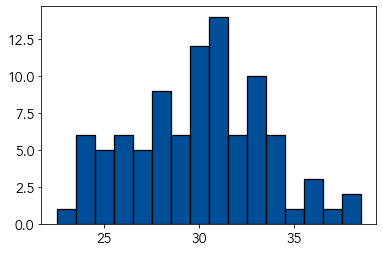

53.76% of Midfielders and Forwards are 30 and under (min 20 90s played)


In [939]:
vals = df_pos_p90['age']
plt.hist(vals,bins=np.arange(vals.min(),vals.max()+1,1),align='left')
plt.show()
print("{:.2f}% of Midfielders and Forwards are 30 and under (min 20 90s played)".format((len(vals[vals <= 30]) / len(vals))*100))

### Initial Shortlist

Begin by getting the *Midfielders* and *Forwards* up to the age of 30 who have played at least 20 90s.

In [940]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender'])

Find the initial top 20 players judging by summing percentile ranks in all the key attributes outlined above.

In [941]:
top = df_pos_p90_per[wing_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_top = df_pos_p90.loc[top] # Raw values
df_top_per = df_pos_p90_per.loc[top] # Percentile ranks

### All-round

With the overall top 20 in hand we can now focus on specific strengths. First, the broad range of *Shooting*, *Dribbling* and *Creating* - so excluding *Crossing* and *Possession Losses*. This is done using the *wing_shot_attr*, *wing_drib_attr* and *wing_creat_attr* created above. I then take the top 10 players based on these attributes alone.

In [949]:
df_top_per.loc[df_top_per[wing_shot_attr+wing_drib_attr+wing_creat_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,mins_played,90s,age,gp,games_started,position,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_through_ball,pen_area_entries,total_cross,cross%,total_contest,contest%,touches_in_opp_box,poss_lost_all
player_id,,,,,,,,,,,,,,,,,,
61278,2652,29.467,28,31,30,Forward,100.0,98.0,84.0,100.0,98.0,100.0,98.0,95.0,100.0,70.0,100.0,0.0
86398,2587,28.744,30,31,30,Midfielder,78.0,80.0,64.0,98.0,100.0,94.0,66.0,72.0,74.0,86.0,50.0,22.0
119718,2269,25.211,26,35,27,Midfielder,92.0,96.0,58.0,66.0,58.0,70.0,76.0,22.0,98.0,30.0,84.0,26.0
88484,2133,23.700,28,36,22,Midfielder,64.0,60.0,70.0,90.0,94.0,98.0,100.0,28.0,60.0,20.0,74.0,2.0
76012,2412,26.800,27,38,28,Forward,58.0,52.0,60.0,70.0,74.0,78.0,56.0,16.0,90.0,72.0,60.0,44.0
76688,2206,24.511,30,34,22,Midfielder,56.0,56.0,52.0,82.0,92.0,76.0,68.0,58.0,46.0,90.0,54.0,62.0
108438,2315,25.722,25,30,28,Forward,90.0,100.0,54.0,60.0,78.0,68.0,78.0,24.0,56.0,32.0,86.0,58.0
76650,3065,34.056,29,37,36,Forward,86.0,88.0,76.0,76.0,96.0,46.0,30.0,26.0,42.0,27.0,72.0,74.0
156689,2830,31.444,24,35,34,Midfielder,48.0,82.0,16.0,78.0,62.0,86.0,90.0,34.0,82.0,68.0,32.0,10.0


Certainly some exciting players:
- PID 61278 stands out as consistently at the top of rankings and 28 years old. Likely one of the best wingers in the league and playing a lot of games. Hence, probably already plays for a top club and would be expensive to sign. But if possible, would be one of the best signings.
- PID 86398 also stands out acroos the board but is 30. Not as much of a shooter but a very good creator.
- **PID 119718** looks interesting. High on this list and only 26. Looking at his rankings it is clear his strengths are shooting and dribbling, although his success is quite low. Likes to push high up the pitch with a large amount of touches in the penalty area. This looks like an excellent signing, especially if you a not a really passing-focused team but still looks competent there.
- PID 88484 is an incredible creator and decent shooter but nothing exceptional. Also crosses a LOT but is not a prolific dribbler.
- PID 76012 is on the younger end of this list at 27 but is ranked highly. Excellent dribbler paired with good creation but average goal-threat.
- **PID 108438** is young and is a serious goal-threat coupled with good creation. Not the most accomplished dribbler.
- **PID 76650** great goal threat (along with good xG/shot) and dangerous creator - particularly from through balls. Not a dribbler and not particularly young at 29.
- PID 156689 incredibly young at 24 with suggests a real prospect. Likes to take many shots but from poor positions. Good creator and very accomplished dribbler.

### Crosser

What if you're looking for someone with the aim of creating space on the wing and just crossing? For this I focus on the *dribbling* and *crossing* attributes.

In [948]:
df_top_per.loc[df_top_per[wing_drib_attr+wing_cross_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,mins_played,90s,age,gp,games_started,position,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_through_ball,pen_area_entries,total_cross,cross%,total_contest,contest%,touches_in_opp_box,poss_lost_all
player_id,,,,,,,,,,,,,,,,,,
61278,2652,29.467,28,31,30,Forward,100.0,98.0,84.0,100.0,98.0,100.0,98.0,95.0,100.0,70.0,100.0,0.0
44989,2500,27.778,30,32,28,Midfielder,20.0,34.0,18.0,96.0,72.0,88.0,92.0,82.0,36.0,98.0,20.0,84.0
86398,2587,28.744,30,31,30,Midfielder,78.0,80.0,64.0,98.0,100.0,94.0,66.0,72.0,74.0,86.0,50.0,22.0
115157,2211,24.567,29,33,25,Midfielder,28.0,24.0,34.0,88.0,80.0,74.0,72.0,88.0,58.0,78.0,46.0,48.0
80629,2476,27.511,29,37,29,Midfielder,46.0,50.0,40.0,94.0,82.0,96.0,96.0,86.0,62.0,36.0,18.0,20.0
156689,2830,31.444,24,35,34,Midfielder,48.0,82.0,16.0,78.0,62.0,86.0,90.0,34.0,82.0,68.0,32.0,10.0
84471,1827,20.300,30,31,23,Midfielder,52.0,86.0,24.0,86.0,46.0,90.0,94.0,56.0,66.0,48.0,40.0,28.0
76688,2206,24.511,30,34,22,Midfielder,56.0,56.0,52.0,82.0,92.0,76.0,68.0,58.0,46.0,90.0,54.0,62.0
98961,3038,33.756,28,38,35,Midfielder,32.0,40.0,22.0,64.0,90.0,62.0,62.0,74.0,44.0,76.0,28.0,70.0


- **PID 156689** The first player on this list under the age of 28 and at 24 is very young. Attempts a lot of dribbles with decent success and a lot of crosses, although success there is not as high. Also a competent creator - although many on this list are.

**Final Picks:** 119718, 108438, 156689

## Centre Back

As metioned when possession adjusting earlier, defensive metrics tend to describe style rather than quality and it can therefore be a bit more difficult to identify good defenders from this data alone.

I will use *Tackling* and *Aerial Duels* as a baseline for defensive ability and then supplement this with *interceptions*, *possession losses*, *fouls*, *passes*, *long balls* and *final third entries* to get an idea of their style. Champions League teams will be the dominant team in many games they play and I therefore think it is important to find centre backs that are comfortable on the ball.

Let's pick the key attributes:

In [950]:
cb_attr_key = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','final_third_entries',
               'poss_lost_all','error_lead_to_shot','fouls',
              'total_pass','total_long_balls','long_ball_to_pass%']

I looked at including *total_through_ball* but defenders barely play any so it was not a great indicator of ball-playing style. Also similar for *total_contest*.

In [951]:
cb_tackle_attr = ['total_tackle_adj','tackle%']
cb_aerial_attr = ['aerial_won_adj','aerial%']
cb_inter_attr = ['interception_adj']
cb_pass_attr = ['final_third_entries']

In [952]:
df_def_p90, df_def_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,exclude_pos=['Goalkeeper','Midfielder','Forward'])

### Age Profile

Let's take a quick look at the age profile of defenders who have played at least 20 90s.

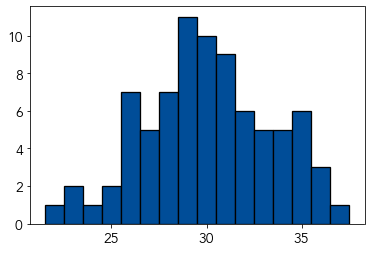

56.79% of Defenders are 30 and under (min 20 90s played)


In [953]:
vals = df_def_p90['age']
plt.hist(vals,bins=np.arange(vals.min(),vals.max()+1,1),align='left')
plt.show()
print("{:.2f}% of Defenders are 30 and under (min 20 90s played)".format((len(vals[vals <= 30]) / len(vals))*100))

We see the most common ages are 29 and 30 and most defenders are within 4 years of 30. While the peak age range of defenders may tend to be higher than other positions, I will again only consider players 30 and under.

### Initial Shortlist

Begin by getting all *Defenders* up to the age of 32 and having played 20 90s. I consider a slightly old maximum age here as centre backs tend to have longer playing careers.

In [964]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,age_range=(0,32),exclude_pos=['Goalkeeper','Midfielder','Forward'])

I will combine these DataFrames with the results from the earlier PCA analysis (in the form of the `df_fbcb_pca` DataFrame) identifying centre backs and full backs. Only players with a negative value in Principal Component 0 (which I have labelled *fb*) will be considered as centre backs.

In [965]:
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [966]:
print("Total number of defenders:",len(df_pos_p90_per))
print("Total number of centre backs:",len(df_pos_p90_per[df_pos_p90_per['fb'] <= 0]))

Total number of defenders: 61
Total number of centre backs: 30


Excluding what I believe to be mostly FBs has cut available players in half. I think this makes sense, you wouldn't really expect most clubs to have more than 2 CBs make more than 20 90s.

In [967]:
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

I had considered using *error_lead_to_shot* as an identifier for centre backs who tend to make mistakes. However, 23/30 defenders have zero errors leading to shots which introduces issues when trying to create percentile rankings and this therefore didn't work too well.

In [969]:
print(len(df_pos_p90[df_pos_p90['error_lead_to_shot'] == 0]),"centre backs have zero errors leading to shots.")

23 centre backs have zero errors leading to shots.


### Tackling and Aerial

Unlike the Winger analysis, I do not find an initial 20 player shortlist based on the sum of percentiles of all key attributes. Instead, as mentioned, I start by finding those the top 20 players in tackling and aerial abilities and investigate further from there. Mainly, I will look at *interceptions* and further style choices such as *final_third_entries*, *total_pass* and *long_ball_to_pass%* to understand how comfortable they are passing/progressing the ball. Finally, can look at errors such as *poss_lost_all*, *error_lead_to_shot* and *fouls* to judge the all-round package. *Age*, as ever, is an important consideration.

In [972]:
top = df_pos_p90_per[cb_tackle_attr + cb_aerial_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top].head(10)

,mins_played,90s,age,gp,games_started,position,total_tackle_adj,tackle%,aerial_won_adj,aerial%,interception_adj,final_third_entries,poss_lost_all,error_lead_to_shot,fouls,total_pass,total_long_balls,long_ball_to_pass%,fb
player_id,,,,,,,,,,,,,,,,,,,
88580,2133,23.700,26,33,24,Defender,50.820,91.803,96.721,91.803,91.803,34.426,98.361,9.836,55.738,100.000,59.016,19.672,-4.023
88477,2302,25.578,30,36,24,Defender,78.689,98.361,75.410,59.836,70.492,4.918,96.721,61.475,39.344,70.492,6.557,6.557,-1.435
77359,2971,33.011,29,34,33,Defender,21.311,86.066,100.000,100.000,59.016,77.049,49.180,61.475,95.082,60.656,100.000,98.361,-2.858
146941,2865,31.833,26,33,33,Defender,52.459,46.721,88.525,96.721,40.984,57.377,70.492,21.311,63.934,80.328,93.443,80.328,-2.868
197319,2270,25.222,25,29,25,Defender,75.410,75.410,85.246,42.623,100.000,95.082,42.623,61.475,0.000,81.967,98.361,90.164,-1.974
90152,1927,21.411,27,26,23,Defender,49.180,22.131,98.361,98.361,65.574,11.475,90.164,0.000,96.721,83.607,63.934,42.623,-3.180
86151,1905,21.167,28,36,21,Defender,86.885,63.934,73.770,36.066,96.721,27.869,75.410,3.279,57.377,86.885,86.885,65.574,-2.796
61814,2799,31.100,32,34,31,Defender,40.984,33.607,93.443,86.885,93.443,40.984,68.852,61.475,59.016,85.246,83.607,63.934,-2.826
11129,3240,36.000,30,36,36,Defender,57.377,40.984,60.656,95.082,21.311,68.852,50.820,61.475,86.885,68.852,85.246,75.410,-2.108


- **PID 88580** ranks highest for combined *tackling* and *aerial* and is only 26. This looks to be the best candidate. Also has high levels of *interceptions* and makes the most *passes* of anyone with a very low proportion of *long balls* (but need to compare to team style). While they very rarely give the ball away, they are not the most *progressive* with very few *final third entries* (although this could be partly due to not playing many long balls) and actually has quite a high number of *errors leading to shots*. Also isn't always a starter in his team.
- **PID 146941** 4th on this list and again only 26. Not such an accomplished *tackler* but competent. Very good *aerial ability* and bit more progressive in terms of *final third entries*. Again makes a lot of *passes* however, this time attempts many more *long balls*. However, has great *possession loss* numbers and *pass%* despite quite a large portion of *long balls*. This suggests someone who is comfortable and calm on the ball and an accurate long passer.
- **PID 197319** 5th and only 25. Good *tackler* but not so good *aerially*. Participates in a lot of *aerial duels* but hasn't got such a good win rate. Looks to be a front-foot defender with the most *interceptions* of any of these CBs. Also plays a good amount of *passes* with very high *final third entries* - however this could be a product of the number of *long balls* they play, which, compared to the other CBs, is a very high proportion of their passes.
- **PID 90152** 6th and 27. Not such an accomplished *tackler* but incredible *aerially*. Also *retains possession* very well and makes a large number of *passes*, not too many of which are *long balls*. So looks very comfortable in possession, as needed by a top Champions League side.

**Final Picks:** 88580, 146941, 90152

## Defensive Midfielder

Finally, we have the Defensive Midfielder role. For this role I will only consider players in the *Midfielder* position. While it is plausible a *Defender* could play this role, I believe a Champions League club will be looking for a player already established in the midfield role. This role will likely involve a mix of defensive duties, ball retention and ball progression. My aim is to consider two different roles within Defensive Midfielder: a classic *Disrupter* whose main role is breaking up opposition play, and a *deep-lying playmaker/progressor* whose role it is to move the ball up the field while still performing some defensive duties.

I will focus on players up to the age of 30 and to have played at least 20 90s. Due to the hybrid nature of this position, there are many attributes that could be considered useful.

In [976]:
dm_attr_key = ['ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj',
               'final_third_entries','pen_area_entries','poss_lost_all','fouls','total_pass','long_ball_to_pass%',
               'total_through_ball','total_att_assist','total_contest','contest%','total_scoring_att','expected_goals']

I can put some of the more important attributes into specific groups for later use in finding players fulfilling specific roles.

In [978]:
dm_tackle_attr = ['total_tackle_adj','tackle%']
dm_aerial_attr = ['aerial_won_adj','aerial%']
dm_inter_attr = ['interception_adj']
dm_pass_attr = ['total_pass','total_through_ball']
dm_creat_attr = ['final_third_entries','total_att_assist']
dm_drib_attr = ['total_contest','contest%']
dm_shot_attr = ['total_scoring_att','expected_goals']

In [977]:
df_dm_p90, df_dm_p90_per = get_df_pos(df_adj,dm_attr_key,nineties=20,exclude_pos=['Goalkeeper','Defender','Forward'])
print("There are {} Midfielders who have played at least 20 90s.".format(len(df_dm_p90)))

There are 65 Midfielders who have played at least 20 90s.


### Age Profile

Let's take a quick look at the age profile of defenders who have played at least 20 90s.

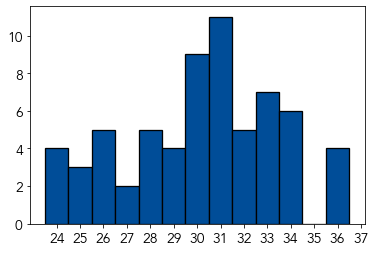

49.23% of Midfielders are 30 and under (min 20 90s played)


In [975]:
vals = df_dm_p90['age']
plt.hist(vals,bins=np.arange(vals.min(),vals.max()+1,1),align='left')
plt.xticks(np.arange(vals.min(),vals.max()+1,1))
plt.show()
print("{:.2f}% of Midfielders are 30 and under (min 20 90s played)".format((len(vals[vals <= 30]) / len(vals))*100))

Most common ages are 30 and 31. Just under half are 30 and below, so it should be ok to again look for players 30 and under.

### Initial Shortlist

In [980]:
top = df_pos_p90_per[dm_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top].head()

,mins_played,90s,age,gp,games_started,position,ball_recovery,blocked_pass,total_tackle_adj,tackle%,aerial_won_adj,aerial%,interception_adj,final_third_entries,pen_area_entries,poss_lost_all,fouls,total_pass,long_ball_to_pass%,total_through_ball,total_att_assist,total_contest,contest%,total_scoring_att,expected_goals
player_id,,,,,,,,,,,,,,,,,,,,,,,,,
44989,2500,27.778,30,32,28,Midfielder,31.250,3.125,96.875,75.000,31.250,62.500,50.000,100.000,84.375,78.125,87.500,100.000,87.500,68.750,96.875,37.500,96.875,50.000,28.125
182539,2336,25.956,24,33,24,Midfielder,100.000,100.000,84.375,68.750,18.750,56.250,81.250,87.500,50.000,12.500,28.125,75.000,84.375,71.875,62.500,90.625,81.250,65.625,25.000
84086,3004,33.378,30,34,33,Midfielder,93.750,34.375,100.000,78.125,78.125,84.375,100.000,93.750,59.375,53.125,37.500,93.750,78.125,56.250,31.250,31.250,87.500,18.750,12.500
76688,2206,24.511,30,34,22,Midfielder,43.750,93.750,65.625,31.250,46.875,65.625,46.875,34.375,68.750,59.375,68.750,78.125,21.875,93.750,75.000,50.000,84.375,78.125,81.250
86398,2587,28.744,30,31,30,Midfielder,9.375,43.750,50.000,65.625,15.625,12.500,15.625,90.625,93.750,21.875,84.375,90.625,25.000,100.000,100.000,81.250,78.125,90.625,96.875


### Disrupters

I will move straight into role-specific players rather than finding some initial shortlist and specifying from there. First is the *Disrupter* role.

In [981]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,dm_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender','Forward'])

In [983]:
dist_attr = dm_tackle_attr + dm_aerial_attr + dm_inter_attr
top = df_pos_p90_per[dist_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top].head(10)

,mins_played,90s,age,gp,games_started,position,ball_recovery,blocked_pass,total_tackle_adj,tackle%,aerial_won_adj,aerial%,interception_adj,final_third_entries,pen_area_entries,poss_lost_all,fouls,total_pass,long_ball_to_pass%,total_through_ball,total_att_assist,total_contest,contest%,total_scoring_att,expected_goals
player_id,,,,,,,,,,,,,,,,,,,,,,,,,
49735,3146,34.956,30,35,35,Midfielder,62.500,56.250,87.500,84.375,100.000,90.625,96.875,84.375,28.125,34.375,3.125,81.250,65.625,9.375,9.375,3.125,45.312,40.625,53.125
84086,3004,33.378,30,34,33,Midfielder,93.750,34.375,100.000,78.125,78.125,84.375,100.000,93.750,59.375,53.125,37.500,93.750,78.125,56.250,31.250,31.250,87.500,18.750,12.500
140264,3184,35.378,30,36,36,Midfielder,81.250,15.625,71.875,81.250,68.750,87.500,84.375,78.125,6.250,87.500,53.125,59.375,100.000,4.688,25.000,6.250,34.375,15.625,6.250
116251,2280,25.333,29,33,26,Midfielder,71.875,50.000,68.750,62.500,87.500,96.875,65.625,59.375,15.625,81.250,46.875,71.875,81.250,25.000,12.500,25.000,53.125,43.750,56.250
89335,2543,28.256,25,35,29,Midfielder,75.000,62.500,90.625,40.625,93.750,75.000,78.125,62.500,31.250,43.750,6.250,40.625,31.250,65.625,28.125,68.750,21.875,75.000,62.500
156305,2020,22.444,27,34,24,Midfielder,25.000,71.875,75.000,34.375,90.625,93.750,75.000,50.000,18.750,71.875,15.625,28.125,53.125,28.125,6.250,21.875,71.875,37.500,37.500
192364,2805,31.167,25,34,31,Midfielder,96.875,78.125,81.250,43.750,59.375,81.250,93.750,56.250,12.500,90.625,50.000,87.500,93.750,15.625,18.750,28.125,93.750,6.250,3.125
200961,2384,26.489,24,31,28,Midfielder,84.375,28.125,62.500,37.500,75.000,78.125,90.625,25.000,9.375,84.375,0.000,65.625,40.625,18.750,34.375,53.125,90.625,12.500,9.375
83578,3006,33.400,28,37,34,Midfielder,46.875,84.375,93.750,12.500,81.250,68.750,71.875,43.750,25.000,68.750,9.375,43.750,59.375,12.500,15.625,12.500,59.375,9.375,31.250


- **PID 192364** 7th on this list, only 25 and started 31 games. Strong ball recovery and blocked passes, competent tackling with high amount but not the best success rate, very good aerially. Also great at intercepting and capable progressing to final third. Holds onto the ball well and seems comfortable passing, although likes to play a lot of long balls. Not a shooter.
- **PID 89335** 5th and 25 with 29 starts. Very similar defensively to PID 192364 although involved in many more aerial engagements but with a slightly lower success rate. Slightly better at progressing the ball and therefore seems to be a bit more risky with passing, reflected in more possession losses. Doesn't pass as much but plays far fewer long balls. This progressive passing can be seen in a high amount of attempted *through balls*. Likes to dribble more and shoots quite a bit.

### Deep-lying passers/playmakers

In [985]:
play_attr = dm_tackle_attr + dm_pass_attr + dm_creat_attr
top = df_pos_p90_per[play_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top].head(10)

,mins_played,90s,age,gp,games_started,position,ball_recovery,blocked_pass,total_tackle_adj,tackle%,aerial_won_adj,aerial%,interception_adj,final_third_entries,pen_area_entries,poss_lost_all,fouls,total_pass,long_ball_to_pass%,total_through_ball,total_att_assist,total_contest,contest%,total_scoring_att,expected_goals
player_id,,,,,,,,,,,,,,,,,,,,,,,,,
44989,2500,27.778,30,32,28,Midfielder,31.250,3.125,96.875,75.000,31.250,62.500,50.000,100.000,84.375,78.125,87.500,100.000,87.500,68.750,96.875,37.500,96.875,50.000,28.125
77390,3171,35.233,28,36,36,Midfielder,87.500,90.625,56.250,71.875,9.375,59.375,56.250,96.875,90.625,6.250,93.750,96.875,50.000,84.375,90.625,15.625,25.000,25.000,34.375
86398,2587,28.744,30,31,30,Midfielder,9.375,43.750,50.000,65.625,15.625,12.500,15.625,90.625,93.750,21.875,84.375,90.625,25.000,100.000,100.000,81.250,78.125,90.625,96.875
84086,3004,33.378,30,34,33,Midfielder,93.750,34.375,100.000,78.125,78.125,84.375,100.000,93.750,59.375,53.125,37.500,93.750,78.125,56.250,31.250,31.250,87.500,18.750,12.500
182539,2336,25.956,24,33,24,Midfielder,100.000,100.000,84.375,68.750,18.750,56.250,81.250,87.500,50.000,12.500,28.125,75.000,84.375,71.875,62.500,90.625,81.250,65.625,25.000
98961,3038,33.756,28,38,35,Midfielder,68.750,25.000,40.625,87.500,50.000,46.875,34.375,75.000,56.250,62.500,65.625,84.375,75.000,90.625,53.125,46.875,62.500,56.250,46.875
80629,2476,27.511,29,37,29,Midfielder,56.250,31.250,28.125,98.438,12.500,15.625,18.750,71.875,96.875,18.750,81.250,50.000,43.750,78.125,93.750,65.625,15.625,71.875,65.625
88484,2133,23.700,28,36,22,Midfielder,50.000,96.875,59.375,90.625,43.750,25.000,62.500,28.125,100.000,0.000,25.000,37.500,37.500,96.875,87.500,62.500,9.375,81.250,87.500
76688,2206,24.511,30,34,22,Midfielder,43.750,93.750,65.625,31.250,46.875,65.625,46.875,34.375,68.750,59.375,68.750,78.125,21.875,93.750,75.000,50.000,84.375,78.125,81.250


- **PID 77390** 2nd, 28 and 36 starts. Good *Tackler* and while has good success rate *aerially*, does not get involved in many duels (but not perticularly important for this role. Excellent *final third* and *penalty area* entries, plays many passes (middle of the road for long ball amount), a lot of *through balls* and *key passes*. Not a very active *shooter*.
- **PID 182539** 5th, 24 and 24 starts. Interestingly top for *ball recovery* and *blocked passes*. Good *tackler* but again not particularly *aerially* good. Good *interceptions* as well so can do a competent job defensively. Great *final third* entries and reasonable *penalty area* entries, so good progressor. Used to playing a good amount of passes, but quite a few long. Good amount of *through balls* and *key passes*. Also someone who likes to *dribble* and has decent success, unlike PID 77390. Takes on more *shooting* oppportunities but tend to be from lower quality positions.

**Final Picks:** *Disrupters* - 192364, 89335, *Deep-lying Playermaker* - 182539

## Visualisation

When creating the final combined visualisations my aim is to provide as many of the important details so that the relevant person at the Champions League club can make an informed decision, but also not overwhelm them with too many numbers. Therefore, the visualisation for each player consists of three main components:
- A header displaying important personal player information, such as their team, age and number of 90s, and some key strengths and weaknesses.
- A Key Attributes bar chart showing how the player performs in key attributes compared to the relevant population of players. The direction and colour of the bars should quickly and obviously make it clear where the player excels without the need to read specific numbers.
- Two radar bar charts showing Player and Team style relevant for the role being considered. This is present to give context to the key attributes and understand how the player tries to play, how their team tries to play, and how these combine.

For each role (*Winger*, *Defensive Midfielder* and *Centre Back*) the individual player visualisations will be combined into a single visualisation, allowing easy comparison between the three options. This combined visual also adds some explainer/details for the visualisations. My aim when creating these combined visuals was something that could easily be viewed digitally or printed out and used - hence, a choice to make each one A4 sized.

To aid and better automate this process I have created a number of functions:
- `plot_bars` creates the horizontal bar charts used for displaying a player's ranking in Key Attributes. It is presented in an "above/below median" form to emphasise how a player performs in comparison to their peers.
- `plot_style` produces polar bar plots represting a player/team style. Bar length represents the rating in each style type.
- `player_overview_plot_gs` combines these visualisations into the single visualisation used for each player, as mentioned above.

In [1005]:
def plot_bars(df_players,df_pos_p90,df_pos_p90_per,attrs,pid,bar_cmap='RdYlGn',annotations=True,ax=None,
              attr_labels=['xG','Shots','xG/Shot','Key Passes','Passing %','Crosses','Touches in Box','Successful Dribbles','Poss. Losses'],
             alpha=0.8,fs=12,pelw=2):
    
    df_pos_p90 = df_pos_p90[attrs]
    df_pos_p90_per = df_pos_p90_per[attrs]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    cmap = plt.get_cmap(bar_cmap)
    norm = mpl.colors.Normalize(vmin=0, vmax=100)

    y_range = np.arange(len(attrs),0,-1)

    ax.barh(np.arange(len(attrs),0,-1),df_pos_p90_per.loc[pid].values - 50,left=50,color=cmap(norm(df_pos_p90_per.loc[pid].values)),alpha=alpha)
    ax.axvline(50,c='k',lw=1,ls='--')
    for i,attr in enumerate(attrs):
        if df_pos_p90_per.loc[pid,attr] >= 75:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
        elif df_pos_p90_per.loc[pid,attr] >= 50:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
        elif df_pos_p90_per.loc[pid,attr] <= 25:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
        else:
            if '%' in attr:
                ax.annotate('{}'.format(round(df_pos_p90.loc[pid,attr]*100)),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=pelw,foreground="w")])

    ax.set_xlim(0,100)
    ax.set_yticks(np.arange(len(attrs),0,-1))
    ax.set_yticklabels(attr_labels,size=fs,weight='medium')
    ax.set_xticks(np.arange(0,125,25))
    ax.tick_params(bottom=False,left=False,labelbottom=False)
    for i in ['top','bottom']:
        ax.spines[i].set_visible(False)

    ax.grid(axis='x',ls='--',alpha=1)
    ax.text(0.5,1,'Median',ha='center',va='bottom',transform=ax.transAxes,size=fs)
    
    if annotations:
        ax.text(0,1.22,"Player ID: {}".format(pid),transform=ax.transAxes,fontsize=fs,fontweight='bold',ha='left',va='bottom')
        ax.text(0,1.15,"{}".format(df_players.loc[pid,'position']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='left',va='bottom')
        ax.text(0,1.1,"Values per 90 minutes played",transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='left',va='bottom')

        ax.text(1.,1.22,"Age: {}".format(df_players.loc[pid,'age']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.15,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.1,"{} Games Played, {} Starts".format(df_players.loc[pid,'gp'],df_players.loc[pid,'games_started']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')

        #line = lines.Line2D([-10,110], [10.5,10.5], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        line = lines.Line2D([-0.1,1.1], [1.05,1.05], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        ax.add_line(line)

        ax.text(0.5,-0.1,"Compared to all players who have played at least 10 90s.",transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='center',va='bottom')
    
    return ax

In [1006]:
def plot_style(df_style,pid,colors=None,labels=None,ax=None,fs=12,fss=10,alpha=0.8):
    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='polar')

    # Plot bars
    bot = 0.3
    radii = df_style.loc[pid].to_numpy()
    theta = np.linspace(np.pi/len(radii),2*np.pi+np.pi/len(radii),len(radii),endpoint=False)
    bars = ax.bar(theta,radii,width=2*np.pi/len(radii),bottom=bot)

    # Set bar properties
    if colors is None:
        colors = ['#f38181', '#fce38a', '#eaffd0', '#95e1d3','#004d98','#f08a5d','#aa96da']
    for i,bar in enumerate(bars):
        bar.set_alpha(alpha)
        bar.set_ec('k')
        bar.set_fc(colors[i])
        bar.set_lw(2)

    # Add thin lines separating sections
    angles = np.linspace(0,2*np.pi,len(radii),endpoint=False)
    for a in angles:
        ax.plot([a,a],[0,1+bot],c='k',lw=1,zorder=1)

    # Add central white circle
    patch = Circle((0,0),radius=bot,fc='w',transform=ax.transProjectionAffine + ax.transAxes,zorder=2)
    ax.add_patch(patch)
    
    path_effects = [patheffects.withStroke(linewidth=2,foreground="w")]
    # Annotations
    for i,ang in enumerate(theta):
        if labels is not None:
            alpha_text = 0.5
            if len(labels[i]) > 8:
                fsl = fss
            else:
                fsl = fs
            if ang <= np.pi/2:
                ax.text(ang,bot+0.02,labels[i],rotation=90-np.degrees(ang),size=fsl,weight='medium',c='0.3',ha='left',path_effects=path_effects,alpha=alpha_text)
            elif ang < np.pi:
                ax.text(ang,bot,labels[i],rotation=90-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='left',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang == np.pi:
                ax.text(ang,bot,labels[i],rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang < (3*np.pi)/2:
                ax.text(ang,bot,labels[i],rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang >= (3*np.pi)/2:
                ax.annotate(labels[i],(ang,bot+0.04),rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',path_effects=path_effects,alpha=alpha_text)

    ax.set_ylim(0,1+bot)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(theta)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_visible(True)
    ax.spines['polar'].set_linewidth(1)
    
    return ax

In [1007]:
def player_overview_plot_gs(pid,df,df_players,df_pos_p90,df_pos_p90_per,df_style,df_style_team,attr_plot,strength_text,weak_text,attr_labels,style_labels,ax_head,ax1,ax2,ax3,ax_gap=None,
                         b_cmap=RdYlGn_9.mpl_colormap,style_colors=Sunset_7.mpl_colors,fs=10):

    tid = df[df['player_id'] == pid]['team_id'].iloc[0]

    ax_head.axis('off')
    line = lines.Line2D([-0.15,1.0], [0.,0.], lw=1.,color='k',clip_on=False,transform=ax_head.transAxes)
    ax_head.add_line(line)

    if ax_gap is not None:
        ax_gap.axis('off')
        line = lines.Line2D([0.1,0.9], [0.5,0.5], lw=1.,color='k',clip_on=False,transform=ax_gap.transAxes)
        ax_gap.add_line(line)

    tfrm = ax_head.transAxes
    # Heading info
    ax_head.set_xlim(0,1)
    ax_head.set_ylim(0,1)
    ax_head.text(-0.15,1,f"Player ID: {pid}",transform=tfrm,size=14,weight='bold',ha='left',va='top')
    ax_head.text(-0.15,0.27,f"Team ID: {tid}",transform=tfrm,size=fs,weight='normal',ha='left',va='bottom')
    ax_head.text(-0.15,0.,f"Team Rank: {df_points.index.get_loc(tid)+1}",transform=tfrm,size=fs,weight='normal',ha='left',va='bottom')
    ax_head.text(0.20,0.54,"Age: {}".format(df_players.loc[pid,'age']),transform=tfrm,size=fs,weight='normal',ha='right',va='bottom')
    ax_head.text(0.20,0.27,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=tfrm,size=fs,weight='normal',ha='right',va='bottom')
    ax_head.text(0.20,0.,f"({df_players.loc[pid,'gp']} GP, {df_players.loc[pid,'games_started']} Starts)",transform=tfrm,size=fs,weight='normal',ha='right',va='bottom')

    #Strengths and Weaknesses
    line = lines.Line2D([0.21,0.21], [0.,1.], lw=1.,color='k',transform=tfrm)
    ax_head.add_line(line)
    htext(s='<Strengths:>',x=0.24,y=1,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    y_coords = [0.7,0.4]
    x_coords = [0.22,0.42]
    for i,t in enumerate(strength_text):
        htext(s=t,x=x_coords[i//2],y=y_coords[i%2],highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    
    htext(s='<Weaknesses:>',x=0.72,y=1,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    y_coords = [0.7,0.4]
    x_coords = [0.7,0.82]
    for i,t in enumerate(weak_text):
        htext(s=t,x=x_coords[i//2],y=y_coords[i%2],highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    
    # Plot headings
    ax_head.text(0.15,-0.1,"Key Attributes",transform=tfrm,size=12,weight='bold',ha='left',va='top')
    ax_head.text(0.73,-0.1,"Styles",transform=tfrm,size=12,weight='bold',ha='left',va='top')

    # Bar plot
    tfrm = ax1.transAxes
    ax1 = plot_bars(df_players,df_pos_p90,df_pos_p90_per,attr_plot,pid,attr_labels=attr_labels,annotations=False,ax=ax1,
                   bar_cmap=b_cmap,fs=8,pelw=2)

    # Player style
    tfrm = ax2.transAxes
    ax2 = plot_style(df_style,pid,labels=style_labels,ax=ax2,colors=style_colors,fs=9,fss=8)
    ax2.text(0.5,1.02,"PLAYER",transform=tfrm,size=10,c='0.4',alpha=0.8,ha='center',va='bottom')

    # Team style
    tfrm = ax3.transAxes
    ax3 = plot_style(df_style_team,tid,labels=style_labels,ax=ax3,colors=style_colors,fs=9,fss=8)
    ax3.text(0.5,1.02,"TEAM",transform=tfrm,size=10,c='0.4',alpha=0.8,ha='center',va='bottom')

    #plt.tight_layout()
    #plt.show()

### Centre Back

In [986]:
cb_attr_plot = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','fouls','poss_lost_all',
                'pass%']

In [987]:
cb_attr_key = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','total_clearance',
               'final_third_entries','poss_lost_all','error_lead_to_shot','fouls','total_pass','pass%',
               'total_long_balls','long_ball_to_pass%']

In [988]:
tackle_attr = ['total_tackle_adj']
aerial_attr = ['aerial_won_adj']
inter_attr = ['interception_adj']
pass_attr = ['total_pass']
long_attr = ['total_long_balls']
foul_attr = ['fouls']
style_attr_cb = [tackle_attr,aerial_attr,inter_attr,pass_attr,long_attr,foul_attr]

In [989]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,age_range=(0,32),exclude_pos=['Goalkeeper','Midfielder','Forward'])
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

In [990]:
df_style_cb = get_df_style(df_adj,style_attr_cb,styles=['tackle','aerial','inter','pass','long','foul'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'],special_pos='Centre Back')
df_style_team = get_df_style(df_adj,style_attr_cb,styles=['tackle','aerial','inter','pass','long','foul'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'],team=True)

In [991]:
attr_labels = ['Tackles','Tackle %','Aerial Duels Won','Aerial Duel %','Interceptions','Fouls','Poss. Losses','Pass %']
style_labels = ['TACKLING','AERIAL','INTERCEPT','PASSING','LONG BALL','FOULS']
strength_texts = [["<+> Successful tackler","<+> Comfortable passer","<+> Excellent in the air","<+> Retains possession well"],
                 ["<+> Excellent aerially","<+> Comfortable passer","<+> Accurate long passer","<+> Started every game played"],
                 ["<+> Dominant in the air","<+> Comfortable passer","<+> Plays for a top side","<+> Retains possession well"]]
weak_texts = [[u"<\u2212> Only 24 starts in 33 GP"],
              [u"<\u2212> Average tackler",u"<\u2212> Lacks high-level experience"],
              [u"<\u2212> Poor tackle success"]]

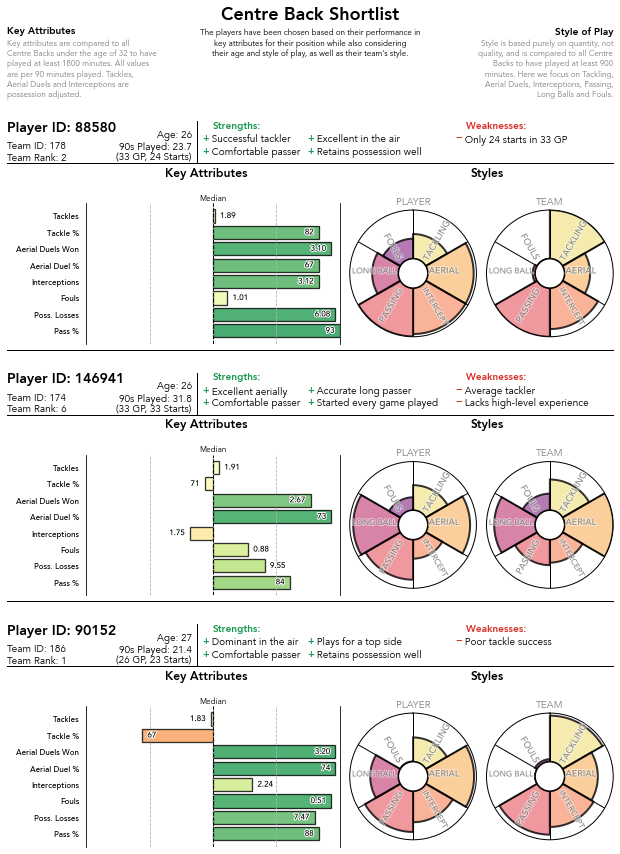

In [992]:
fig = plt.figure(figsize=(8.5,11.75),constrained_layout=True)
gs0 = fig.add_gridspec(6, 1,height_ratios=[0.5,1,0.1,1,0.1,1])

pos = 'Centre Back'
pid = [88580,146941,90152]

gs = gs0[0].subgridspec(1,1)
ax_title = fig.add_subplot(gs[:])
gs = gs0[2].subgridspec(1,1)
ax_gap1 = fig.add_subplot(gs[:])
gs = gs0[4].subgridspec(1,1)
ax_gap2 = fig.add_subplot(gs[:])

ax_title.axis('off')
ax_title.set_xlim(0,1)
ax_title.set_ylim(0,1)

ax_gap1.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap1.transAxes)
ax_gap1.add_line(line)

ax_gap2.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap2.transAxes)
ax_gap2.add_line(line)

ax_heads = []
ax1s = []
ax2s = []
ax3s = []
#ax_gaps = []
#ax_gaps2 = []

# Initialise all subplots first otherwise htext has issues
for i in [1,3,5]:
    gs = gs0[i].subgridspec(2,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,1])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1],projection='polar')
    ax3 = fig.add_subplot(gs[1,2],projection='polar')
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    #ax_gaps.append(ax_gap)
    #ax_gaps2.append(ax_gap2)
    
"""for i in range(1,4):
    gs = gs0[i].subgridspec(3,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,1,0.2])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1],projection='polar')
    #ax_gap = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[1,2],projection='polar')
    ax_gap2 = fig.add_subplot(gs[2,:])
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    #ax_gaps.append(ax_gap)
    ax_gaps2.append(ax_gap2)"""
    
"""for i in range(1,4):
    gs = gs0[i].subgridspec(4,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,0.1,1,0.2])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1:3,0])
    ax2 = fig.add_subplot(gs[2,1],projection='polar')
    ax_gap = fig.add_subplot(gs[1,1:3])
    ax3 = fig.add_subplot(gs[2,2],projection='polar')
    ax_gap2 = fig.add_subplot(gs[3,:])
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    ax_gaps.append(ax_gap)
    ax_gaps2.append(ax_gap2)"""

tfrm = ax_title.transAxes
ax_title.text(0.5,1,"Centre Back Shortlist",transform=tfrm,size=18,weight='bold',ha='center',va='top')
t = f"The players have been chosen based on their performance in key attributes for their position while also considering their age and style of play, as well as their team's style."
ax_title.text(0.5,0.8,fill(t,60),transform=tfrm,size=8,ha='center',va='top')

ax_title.text(0,0.82,"Key Attributes",transform=tfrm,size=10,weight='bold',ha='left',va='top')
t = f"Key attributes are compared to all {pos}s under the age of 32 to have played at least 1800 minutes. All values are per 90 minutes played. Tackles, Aerial Duels and Interceptions are possession adjusted."
ax_title.text(0,0.7,fill(t,40),transform=tfrm,size=8,c='0.5',ha='left',va='top')
#arrow1 = FancyArrowPatch((0.33,0.63),(0.21,0.63),connectionstyle="arc3,rad=0.2",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
#ax_title.add_patch(arrow1)

ax_title.text(1,0.82,"Style of Play",transform=tfrm,size=10,weight='bold',ha='right',va='top')
t = f"Style is based purely on quantity, not quality, and is compared to all {pos}s to have played at least 900 minutes. Here we focus on Tackling, Aerial Duels, Interceptions, Passing, Long Balls and Fouls."
ax_title.text(1,0.7,fill(t,40),transform=tfrm,size=8,c='0.5',ha='right',va='top')
#arrow2 = FancyArrowPatch((0.65,0.45),(0.77,0.51),connectionstyle="arc3,rad=0.3",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
#ax_title.add_patch(arrow2)

for i in range(3):
    ax_head = ax_heads[i]
    ax1 = ax1s[i]
    ax2 = ax2s[i]
    ax3 = ax3s[i]
    #ax_gap = ax_gaps[i]
    #ax_gap.axis('off')
    #ax_gap.set_xlim(0,1)
    #ax_gap.set_ylim(0,1)
    #ax_gap.text(0.5,0.,"Tackles, Aerial, Interceptions, Passes, Long Balls, Fouls",transform=ax_gap.transAxes,ha='center',va='bottom')
    #labels = "<Tackles>, <Aerial>, <Interceptions>, <Passes>, <Long Balls>, <Fouls>"
    #htext(labels,0.5,0,highlight_colors=Sunset_7.mpl_colors[:6],ha='center',va='bottom',size=12,ax=ax_gap,path_effects=[patheffects.withStroke(linewidth=0.1,foreground="k")])
    #ax_gap2 = ax_gaps2[i]
    #ax_gap2.axis('off')
    player_overview_plot_gs(pid[i],df,df_players,df_pos_p90,df_pos_p90_per,df_style_cb,df_style_team,cb_attr_plot,strength_texts[i],weak_texts[i],attr_labels,style_labels,ax_head=ax_head,ax1=ax1,ax2=ax2,ax3=ax3)
    
    #ax2.text(0.5,1.02,"PLAYER",transform=ax2.transAxes,size=10,c='0.4',alpha=0.8,ha='center',va='bottom')
    #ax3.text(0.5,1.02,"TEAM",transform=ax3.transAxes,size=10,c='0.4',alpha=0.8,ha='center',va='bottom')

#fig.savefig("centre_back.pdf")
plt.show()

### Winger

In [993]:
wing_attr_plot = ['goals','expected_goals','total_scoring_att','total_att_assist','accurate_cross','won_contest','pen_area_entries','poss_lost_all']
wing_attr_key = ['goals','expected_goals','total_scoring_att','xG/shot','total_att_assist','total_pass','pass%','total_through_ball',
                 'total_cross','accurate_cross','cross%','total_contest','won_contest','contest%','pen_area_entries','touches_in_opp_box','poss_lost_all']

In [995]:
shot_attr = ['total_scoring_att']
pass_attr = ['total_pass']
drib_attr = ['total_contest']
cross_attr = ['total_cross']
creat_attr = ['total_att_assist','total_through_ball','pen_area_entries']
style_attr_wing = [shot_attr,pass_attr,drib_attr,cross_attr,creat_attr]

In [994]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,wing_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender'])

In [996]:
df_style_wing = get_df_style(df_adj,style_attr_wing,styles=['shot','pass','drib','cross','creat'],
             exclude_pos=['Goalkeeper','Defender'])
df_style_team = get_df_style(df_adj,style_attr_wing,styles=['shot','pass','drib','cross','creat'],
             exclude_pos=['Goalkeeper','Defender'],team=True)

In [997]:
attr_labels = ['Goals','xG','Shots','Key Passes','Successful Crosses','Successful Dribbles','Penalty Area Entries','Poss. Losses']
style_labels = ['SHOOTING','PASSING','DRIBBLING','CROSSING','CREATION']
strength_texts = [["<+> Serious goal threat","<+> Excellent Dribbler","<+> Good chance creator","<+> Experience at high level"],
                 ["<+> Serious goal threat","<+> Good chance creator","<+> Retains possession well"],
                 ["<+> Great chance creator","<+> Good crosser","<+> Good dribbler"]]
weak_texts = [[u"<\u2212> Conceeds possession often"],
              [u"<\u2212> Average dribbler",u"<\u2212> Lacks high-level experience"],
              [u"<\u2212> Conceeds possession very often",u"<\u2212> Average goal threat"]]

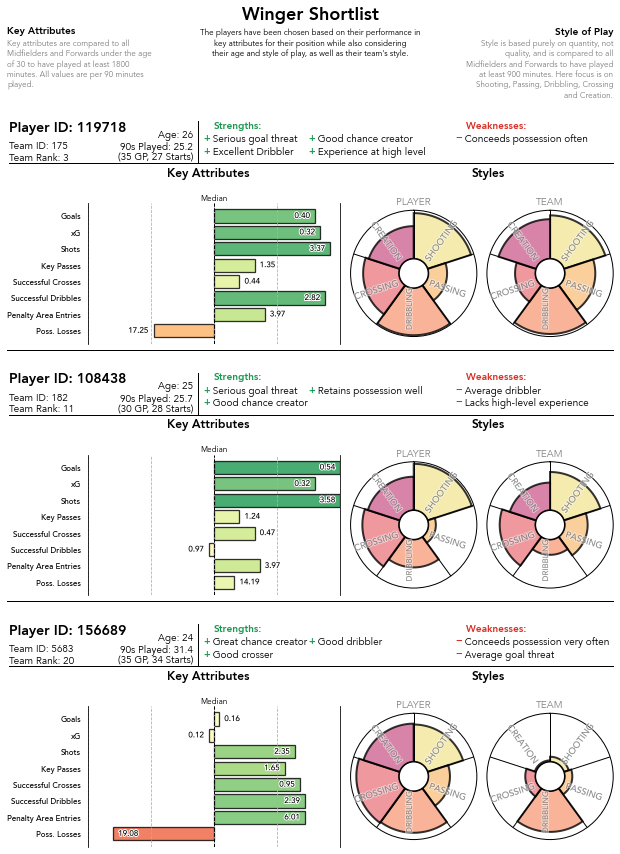

In [998]:
fig = plt.figure(figsize=(8.5,11.75),constrained_layout=True)
gs0 = fig.add_gridspec(6, 1,height_ratios=[0.5,1,0.1,1,0.1,1])#,hspace=0.5)

pos = 'Winger'
pid = [119718,108438,156689]

gs = gs0[0].subgridspec(1,1)
ax_title = fig.add_subplot(gs[:])
gs = gs0[2].subgridspec(1,1)
ax_gap1 = fig.add_subplot(gs[:])
gs = gs0[4].subgridspec(1,1)
ax_gap2 = fig.add_subplot(gs[:])

ax_title.axis('off')
ax_title.set_xlim(0,1)
ax_title.set_ylim(0,1)

ax_gap1.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap1.transAxes)
ax_gap1.add_line(line)

ax_gap2.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap2.transAxes)
ax_gap2.add_line(line)

ax_heads = []
ax1s = []
ax2s = []
ax3s = []
ax_gaps = []
ax_gaps2 = []
# Initialise all subplots first
for i in [1,3,5]:
    gs = gs0[i].subgridspec(2,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,1])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1],projection='polar')
    ax3 = fig.add_subplot(gs[1,2],projection='polar')
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)

tfrm = ax_title.transAxes
ax_title.text(0.5,1,"Winger Shortlist",transform=tfrm,size=18,weight='bold',ha='center',va='top')
t = f"The players have been chosen based on their performance in key attributes for their position while also considering their age and style of play, as well as their team's style."
ax_title.text(0.5,0.8,fill(t,60),transform=tfrm,size=8,ha='center',va='top')

ax_title.text(0,0.82,"Key Attributes",transform=tfrm,size=10,weight='bold',ha='left',va='top')
t = f"Key attributes are compared to all Midfielders and Forwards under the age of 30 to have played at least 1800 minutes. All values are per 90 minutes played."
ax_title.text(0,0.7,fill(t,40),transform=tfrm,size=8,c='0.5',ha='left',va='top')
#arrow1 = FancyArrowPatch((0.33,0.63),(0.21,0.63),connectionstyle="arc3,rad=0.2",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
#ax_title.add_patch(arrow1)

ax_title.text(1,0.82,"Style of Play",transform=tfrm,size=10,weight='bold',ha='right',va='top')
t = f"Style is based purely on quantity, not quality, and is compared to all Midfielders and Forwards to have played at least 900 minutes. Here focus is on Shooting, Passing, Dribbling, Crossing and Creation."
ax_title.text(1,0.7,fill(t,40),transform=tfrm,size=8,c='0.5',ha='right',va='top')
#arrow2 = FancyArrowPatch((0.65,0.45),(0.77,0.51),connectionstyle="arc3,rad=0.3",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
#ax_title.add_patch(arrow2)

for i in range(3):
    ax_head = ax_heads[i]
    ax1 = ax1s[i]
    ax2 = ax2s[i]
    ax3 = ax3s[i]
    player_overview_plot_gs(pid[i],df,df_players,df_pos_p90,df_pos_p90_per,df_style_wing,df_style_team,wing_attr_plot,strength_texts[i],weak_texts[i],attr_labels,style_labels,ax_head=ax_head,ax1=ax1,ax2=ax2,ax3=ax3)

#fig.savefig("winger.pdf")
plt.show()

### Defensive Midfielder

In [999]:
dm_attr_plot = ['total_tackle_adj','aerial_won_adj','interception_adj','pass%','won_contest','final_third_entries','total_att_assist','poss_lost_all','fouls']
dm_attr_key = ['ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj',
               'final_third_entries','pen_area_entries','poss_lost_all','fouls',
              'total_pass','pass%','long_ball_to_pass%','total_through_ball','accurate_through_ball','total_att_assist','total_contest','won_contest','contest%',
              'total_scoring_att','expected_goals']

In [1000]:
tackle_attr = ['total_tackle_adj']
aerial_attr = ['aerial_won_adj']
inter_attr = ['interception_adj']
pass_attr = ['total_pass']
creat_attr = ['total_att_assist','total_through_ball','final_third_entries']
drib_attr = ['total_contest']
shot_attr = ['total_scoring_att']
style_attr_dm = [tackle_attr,aerial_attr,inter_attr,pass_attr,creat_attr,drib_attr]

In [1001]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,dm_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender','Forward'])

In [1002]:
df_style_dm = get_df_style(df_adj,style_attr_dm,styles=['tackle','aerial','inter','pass','creat','drib'],
             exclude_pos=['Goalkeeper','Defender','Forward'])
df_style_team = get_df_style(df_adj,style_attr_dm,styles=['tackle','aerial','inter','pass','creat','drib'],
             exclude_pos=['Goalkeeper','Defender','Forward'],team=True)

In [1003]:
attr_labels = ['Tackles','Aerial Duels Won','Interceptions','Pass %','Successful Dribbles','Final Third Entries','Key Passes','Poss. Losses','Fouls']
style_labels = ['TACKLING','AERIAL','INTERCEPT','PASSING','CREATION','DRIBBLING']
strength_texts = [["<+> Excellent anticipation","<+> Great tackler","<+> Retains possession well"],
                 ["<+> Excellent tackler","<+> Excellent aerially","<+> Competent progressor"],
                 ["<+> Excellent progressor","<+> Fantastic dribbler","<+> Good tackling and anticipation","<+> Competent creator"]]
weak_texts = [[u"<\u2212> Only adequate aerially",u"<\u2212> Not particularly progressive"],
              [u"<\u2212> Loose with possession",u"<\u2212> Not particularly creative"],
              [u"<\u2212> Conceeds possession very often",u"<\u2212> Poor aerially"]]

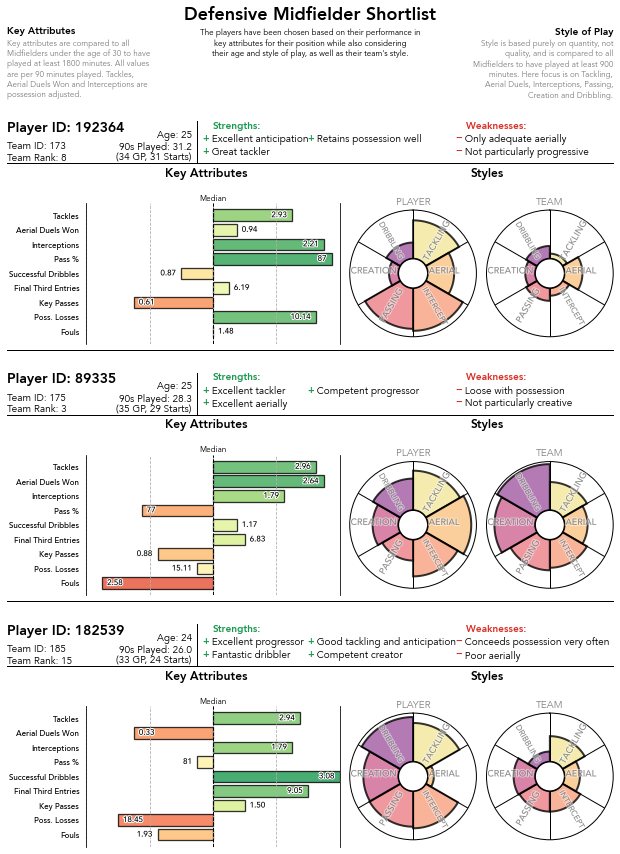

In [1004]:
fig = plt.figure(figsize=(8.5,11.75),constrained_layout=True)
gs0 = fig.add_gridspec(6, 1,height_ratios=[0.5,1,0.1,1,0.1,1])#,hspace=0.5)

pos = 'Defensive Midfielder'
pid = [192364,89335,182539]

gs = gs0[0].subgridspec(1,1)
ax_title = fig.add_subplot(gs[:])
gs = gs0[2].subgridspec(1,1)
ax_gap1 = fig.add_subplot(gs[:])
gs = gs0[4].subgridspec(1,1)
ax_gap2 = fig.add_subplot(gs[:])

ax_title.axis('off')
ax_title.set_xlim(0,1)
ax_title.set_ylim(0,1)

ax_gap1.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap1.transAxes)
ax_gap1.add_line(line)

ax_gap2.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap2.transAxes)
ax_gap2.add_line(line)

ax_heads = []
ax1s = []
ax2s = []
ax3s = []
ax_gaps = []
ax_gaps2 = []
# Initialise all subplots first
for i in [1,3,5]:
    gs = gs0[i].subgridspec(2,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,1])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1],projection='polar')
    ax3 = fig.add_subplot(gs[1,2],projection='polar')
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)

tfrm = ax_title.transAxes
ax_title.text(0.5,1,f"{pos} Shortlist",transform=tfrm,size=18,weight='bold',ha='center',va='top')
t = f"The players have been chosen based on their performance in key attributes for their position while also considering their age and style of play, as well as their team's style."
ax_title.text(0.5,0.8,fill(t,60),transform=tfrm,size=8,ha='center',va='top')

ax_title.text(0,0.82,"Key Attributes",transform=tfrm,size=10,weight='bold',ha='left',va='top')
t = f"Key attributes are compared to all Midfielders under the age of 30 to have played at least 1800 minutes. All values are per 90 minutes played. Tackles, Aerial Duels Won and Interceptions are possession adjusted."
ax_title.text(0,0.7,fill(t,40),transform=tfrm,size=8,c='0.5',ha='left',va='top')
#arrow1 = FancyArrowPatch((0.33,0.63),(0.21,0.63),connectionstyle="arc3,rad=0.2",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
#ax_title.add_patch(arrow1)

ax_title.text(1,0.82,"Style of Play",transform=tfrm,size=10,weight='bold',ha='right',va='top')
t = f"Style is based purely on quantity, not quality, and is compared to all Midfielders to have played at least 900 minutes. Here focus is on Tackling, Aerial Duels, Interceptions, Passing, Creation and Dribbling."
ax_title.text(1,0.7,fill(t,40),transform=tfrm,size=8,c='0.5',ha='right',va='top')
#arrow2 = FancyArrowPatch((0.65,0.45),(0.77,0.51),connectionstyle="arc3,rad=0.3",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
#ax_title.add_patch(arrow2)

for i in range(3):
    ax_head = ax_heads[i]
    ax1 = ax1s[i]
    ax2 = ax2s[i]
    ax3 = ax3s[i]
    player_overview_plot_gs(pid[i],df_adj,df_players,df_pos_p90,df_pos_p90_per,df_style_dm,df_style_team,dm_attr_plot,strength_texts[i],weak_texts[i],attr_labels,style_labels,ax_head=ax_head,ax1=ax1,ax2=ax2,ax3=ax3)

#fig.savefig("defensive_midfielder.pdf")
plt.show()

## Plot Layout Testing

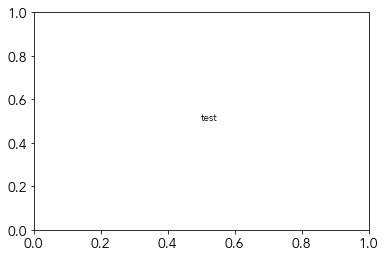

In [586]:
fig,ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
test = ax.text(0.5,0.5,"test")

In [598]:
b = test.get_window_extent()
inv = ax.transData.inverted()
inv.transform(b)

array([[0.5       , 0.48620309],
       [0.54965651, 0.53679176]])

In [ ]:
def plot_style(df_style,pid,colors=None,labels=None,ax=None,fs=12):
    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='polar')

    # Plot bars
    bot = 0.3
    radii = df_style.loc[pid].to_numpy()
    theta = np.linspace(np.pi/len(radii),2*np.pi+np.pi/len(radii),len(radii),endpoint=False)
    bars = ax.bar(theta,radii,width=2*np.pi/len(radii),bottom=bot)

    # Set bar properties
    if colors is None:
        colors = ['#f38181', '#fce38a', '#eaffd0', '#95e1d3','#004d98','#f08a5d','#aa96da']
    for i,bar in enumerate(bars):
        bar.set_alpha(0.8)
        bar.set_ec('k')
        bar.set_fc(colors[i])
        bar.set_lw(3)

    # Add thin lines separating sections
    angles = np.linspace(0,2*np.pi,len(radii),endpoint=False)
    for a in angles:
        ax.plot([a,a],[0,1+bot],c='k',lw=1,zorder=1)

    # Add central white circle
    patch = Circle((0,0),radius=bot,fc='w',transform=ax.transProjectionAffine + ax.transAxes,zorder=2)
    ax.add_patch(patch)

    # Annotations
    for i,ang in enumerate(theta):
        if ang < np.pi:
            if labels is not None:
                ax.annotate(labels[i],(ang,1.2+bot),fontsize=fs,fontweight='medium',annotation_clip=False,ha='left')
            if radii[i] <= 0.5:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
        elif (ang == np.pi) or (ang == 0):
            if labels is not None:
                ax.annotate(labels[i],(ang,1.2+bot),fontsize=fs,fontweight='medium',annotation_clip=False,ha='center')
            if radii[i] <= 0.5:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
        else:
            if labels is not None:
                ax.annotate(labels[i],(ang,1.2+bot),fontsize=fs,fontweight='medium',annotation_clip=False,ha='right')
            if radii[i] <= 0.5:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])

    ax.set_ylim(0,1+bot)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(theta)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_visible(True)
    ax.spines['polar'].set_linewidth(1)
    
    return ax

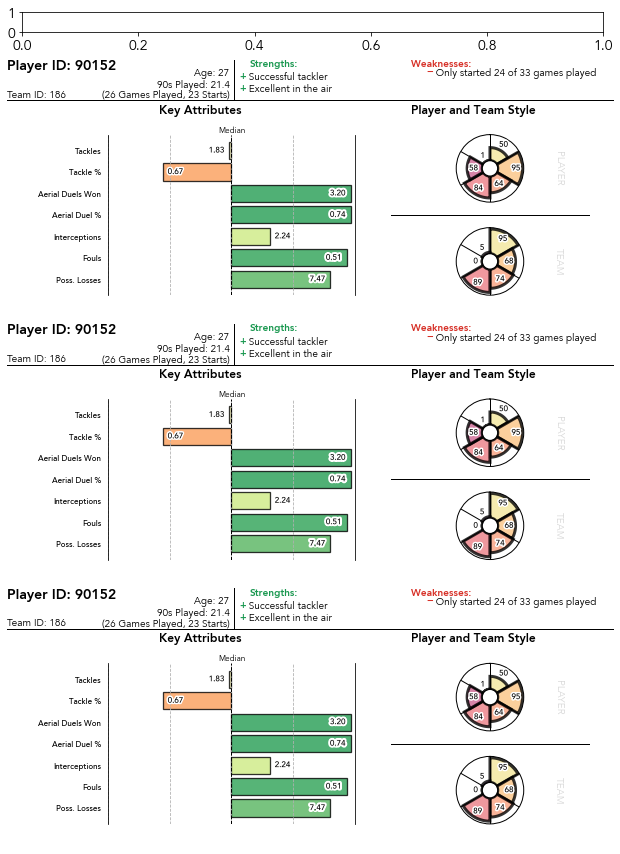

In [302]:
strength_text = "<+> Successful tackler\n<+> Excellent in the air"
weak_text = u"<\u2212> Only started 24 of 33 games played"
key_text = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
style_text = "Player style is compared to all Centre Backs to have played at least 900 minutes."

fig = plt.figure(figsize=(8.5,11.75),constrained_layout=True)
gs0 = fig.add_gridspec(4, 1,height_ratios=[0.2,1,1,1])#,hspace=0.5)

pid = 88580

gs = gs0[0].subgridspec(1,1)
ax_title = fig.add_subplot(gs[:])

#gs00 = []
ax_heads = []
ax1s = []
ax2s = []
ax3s = []
ax_gaps = []
ax_gaps2 = []
# Initialise all subplots first
for i in range(1,4):
    gs = gs0[i].subgridspec(5,2,width_ratios=[1,1],height_ratios=[0.6,1,0.1,1,0.2])
    #gs00.append(gs)
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1:4,0])
    ax2 = fig.add_subplot(gs[1, 1],projection='polar')
    ax_gap = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[3, 1],projection='polar')
    ax_gap2 = fig.add_subplot(gs[4,:])
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    ax_gaps.append(ax_gap)
    ax_gaps2.append(ax_gap2)
    
for i in range(3):
    ax_head = ax_heads[i]
    ax1 = ax1s[i]
    ax2 = ax2s[i]
    ax3 = ax3s[i]
    ax_gap = ax_gaps[i]
    ax_gap2 = ax_gaps2[i]
    #ax_gap2.axis('off')
    player_overview_plot_gs(90152,df,df_players,df_pos_p90,df_pos_p90_per,strength_text,weak_text,key_text,style_text,ax_head=ax_head,ax_gap=ax_gap,ax1=ax1,ax2=ax2,ax3=ax3)
    ax_gap2.axis('off')
    
fig.savefig("test.pdf")
plt.show()

In [ ]:
wing_attr_key2 = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','total_pass','pass%',
                  'total_cross','cross%','touches_in_opp_box','total_contest','contest%','poss_lost_all']

In [46]:
# Select quick top 10 from summed percentiles in key attr
top10 = df_pos_p90_per[wing_attr_key2].sum(axis=1).sort_values(ascending=False).iloc[:10].index
df_top10 = df_pos_p90[wing_attr_key2].loc[top10]
df_top10_per = df_pos_p90_per[wing_attr_key2].loc[top10]

In [49]:
fig,ax = plt.subplots(figsize=(10,8))

players = df_top10.index.to_list()

data = []
for i,p in enumerate(players):
    vals = df[df['player_id'] == p]['expected_goals'].to_list()
    data.append(vals)
    ax.scatter(vals,[i+1]*len(vals),s=10,c='k',zorder=1)
    #np.array(data, dtype=object)
    
bplot = ax.boxplot(data,vert=False,labels=players,patch_artist=True,showmeans=True,meanline=True,medianprops={'color':'k'},zorder=1)
#ax.scatter(data,[i+1]*len(data))

for patch in bplot['boxes']:
    patch.set_facecolor('0.8')
    #patch.set_alpha(0.8)

plt.close()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [ ]:
#from palettable.cartocolors.diverging import Temps_7_r
from palettable.cartocolors.qualitative import Pastel_8
from palettable.cartocolors.sequential import Sunset_7,OrYel_7,PinkYl_7,RedOr_7
from palettable.colorbrewer.diverging import Spectral_3,Spectral_7,RdYlGn_3,RdYlGn_9
from palettable.cmocean.sequential import Deep_8
from palettable.scientific.sequential import LaJolla_8
from palettable.tableau import GreenOrange_6,TableauLight_10

#### Using PCA

In [983]:
pca_attr = ['touches','final_third_entries','pen_area_entries','poss_lost_all','total_cross','total_pass','total_long_balls','total_through_ball','accurate_pass','accurate_through_ball','accurate_cross','total_att_assist','won_contest',
 'total_contest',
 'touches_in_opp_box',
 'total_scoring_att',
 'goals',
 'expected_goals',
 'ontarget_scoring_att',
 'xG/shot',
 'pass%']

In [ ]:
shot_attr = ['total_scoring_att','expected_goals','xG/shot']
pass_attr = ['total_pass','total_through_ball','total_att_assist']
drib_attr = ['won_contest','total_contest','touches_in_opp_box']
cross_attr = ['total_cross','total_long_balls']

In [1167]:
df_pca_p90,df_pca_p90_per = get_df_pos(df,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Defender'])

In [1169]:
X = preprocessing.scale(df_pca_p90[pca_attr])

In [1171]:
pca = PCA(n_components=3)
pca.fit_transform(X);

In [1172]:
comp_rel = pca.components_;

In [1173]:
import seaborn as sns

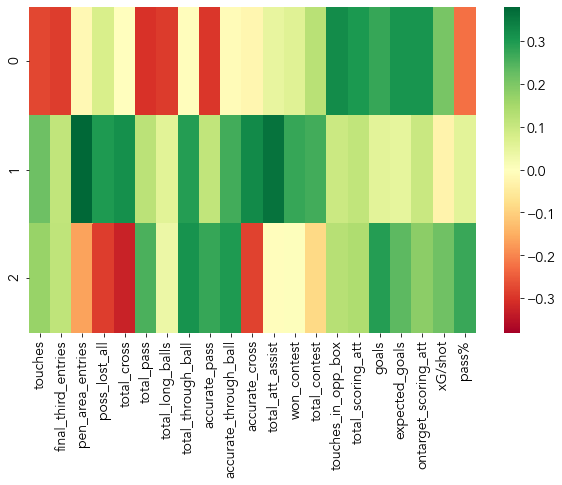

In [1174]:
fig = plt.figure(figsize=(10,6))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')

### Using PCA to find DM from Midfielders

In [1920]:
pca_attr = ['touches','ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%',
           'interception_adj','fouls','error_lead_to_goal','error_lead_to_shot','total_clearance_adj','final_third_entries','pen_area_entries',
           'poss_lost_all','total_pass','pass%','total_long_balls','long_ball_to_pass%','total_through_ball','total_att_assist',
          'won_contest','total_contest','touches_in_opp_box','total_scoring_att','expected_goals']

In [1910]:
'final_third_entries','poss_lost_all','won_contest','total_tackle_adj'

('final_third_entries', 'poss_lost_all', 'won_contest', 'total_tackle_adj')

In [1911]:
pca_attr = ['touches','ball_recovery','blocked_pass','tackle%','aerial_won_adj','aerial%',
           'interception_adj','fouls','total_clearance_adj','pen_area_entries','total_pass','total_long_balls',
            'long_ball_to_pass%','total_through_ball','total_att_assist',
          'total_contest','touches_in_opp_box','total_scoring_att','expected_goals']

In [1921]:
df_pca_p90,df_pca_p90_per = get_df_pos(df_adj,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Defender','Forward'])

In [1922]:
X = preprocessing.scale(df_pca_p90[pca_attr])

In [1933]:
pca = PCA(n_components=4)
pca.fit_transform(X);

In [1934]:
comp_rel = pca.components_;

In [1935]:
import seaborn as sns

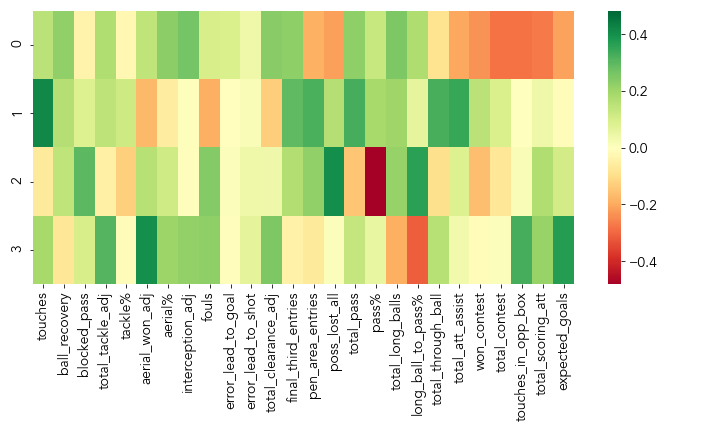

In [1936]:
fig = plt.figure(figsize=(10,6))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')
plt.tight_layout()
plt.show()

In [1939]:
df_dm_pca = pd.DataFrame(data=pca.fit_transform(X),columns=[0,1,2,3],index=df_pca_p90_per.index)

In [1940]:
df_dm_pca.loc[[44989,76688,89335,192364,37055]]

,0,1,2,3
player_id,,,,
44989,2.173,4.829,-0.771,-0.869
76688,-0.597,1.261,-0.649,0.880
89335,0.968,-1.068,0.849,1.873
192364,4.464,0.601,0.169,-1.010
37055,1.772,2.287,-0.945,0.166


## Relation between Attributes

### Are *total_tackle_adj* and *total_pass* related at the team level?

In [1493]:
tackle_adj_attr = ['total_tackle_adj']
tackle_attr = ['total_tackle']
pass_attr = ['total_pass']
style_attr_cb = [pass_attr,tackle_attr,tackle_adj_attr]

In [1494]:
df_style_team = get_df_style(df_adj,style_attr_cb,styles=['pass','tackle','tackle_adj'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'],team=True)

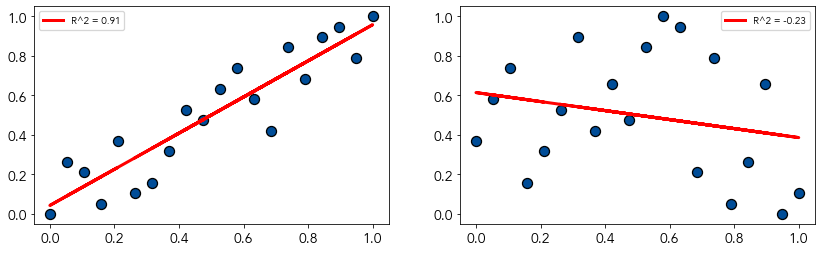

In [1496]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
x = df_style_team['pass'].to_numpy()
y = df_style_team['tackle_adj'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
axs[0].scatter(x,y)
axs[0].plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
axs[0].legend()

y = df_style_team['tackle'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
axs[1].scatter(x,y)
axs[1].plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
axs[1].legend()
plt.show()

Thanks to the possession adjustment *total_tackle_adj* becomes highly correlated with *total_pass*.

### Are *final_third_entries* and *long_ball_to_pass%* related in Centre Backs?

In [2126]:
cb_attr_key = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','final_third_entries',
               'poss_lost_all','error_lead_to_shot','fouls',
              'total_pass','total_long_balls','long_ball_to_pass%']

In [2127]:
cb_tackle_attr = ['total_tackle_adj','tackle%']
cb_aerial_attr = ['aerial_won_adj','aerial%']
cb_inter_attr = ['interception_adj']
cb_pass_attr = ['final_third_entries']

In [2128]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,age_range=(0,32),exclude_pos=['Goalkeeper','Midfielder','Forward'])
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [2129]:
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

In [2137]:
x = df_pos_p90_per['long_ball_to_pass%'].to_numpy()
y = df_pos_p90_per['final_third_entries'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [2138]:
r_value

0.5449914487113119

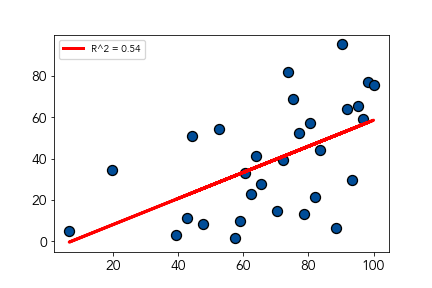

In [2139]:
plt.scatter(x,y)
plt.plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
plt.legend()
plt.show()

So it really seems more long balls is a reasonable indicator of *final_third_entries*. Hence, I am not sure it is appropriate to directly link *final_third_entries* to progression - it could just be a result of clearances.

In [1405]:
x = df_pos_p90_per['long_ball_to_pass%'].to_numpy()
y = df_pos_p90_per['poss_lost_all'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

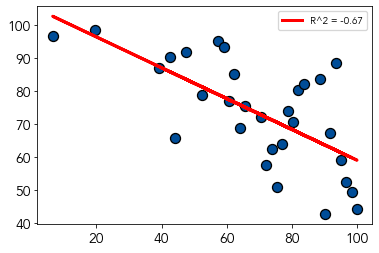

In [1407]:
plt.scatter(x,y)
plt.plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
plt.legend()
plt.show()

We see *long_ball_to_pass%* is a decent indicator of *poss_lost_all*. Hence, when judging *poss_lost_all* keep in mind those that perform a lot of long balls tend to be worse.